# Final Project

# Gathering Data + Setup

In [ ]:
# class VAE(nn.Module):
#     def __init__(self, z_dim=64, siren_config=None):
#         super().__init__()
#         self.z_dim = z_dim
        
#         self.siren_config = {
#             'input_dim': 2 + 2*2*8,  
#             'hidden_dim': 128,       
#             'hidden_layers': 3,       
#             'output_dim': 1
#         }
        
#         if siren_config is not None:
#             self.siren_config.update(siren_config)
        
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 32, 4, stride=2, padding=1),             # 28x28 -> 14x14
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(32, 64, 4, stride=2, padding=1),            # 14x14 -> 7x7
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(64, 128, 3, stride=1, padding=1),           # 7x7 -> 7x7
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Flatten(),
#             nn.Linear(128 * 7 * 7, 512),
#             nn.LeakyReLU(0.2, inplace=True)
#         )
        
#         self.fc_mu = nn.Linear(512, z_dim)
#         self.fc_logvar = nn.Linear(512, z_dim)
        
#         total_weights = SIREN.calc_total_weights(
#             input_dim=self.siren_config['input_dim'],
#             hidden_dim=self.siren_config['hidden_dim'],
#             hidden_layers=self.siren_config['hidden_layers'],
#             output_dim=self.siren_config['output_dim']
#         )
        
#         self.decoder = nn.Sequential(
#             nn.Linear(z_dim, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(1024, total_weights) 
#         )
    
#     def encode(self, x):
#         h = self.encoder(x)
#         return self.fc_mu(h), self.fc_logvar(h)
    
#     def reparameterize(self, mu, logvar):
#         logvar = torch.clamp(logvar, -4, 4)
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std
    
#     def decode(self, z):
#         return self.decoder(z)
    
#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         return self.decode(z), mu, logvar


## NEED VAE IMPLEMENTATION FROM THIS THATS ALL

Using device: cpu
Coordinate shape: torch.Size([784, 34])
Coordinate min/max: -1.0 1.0
Encoded coordinate shape: torch.Size([784, 34])


Epoch 1/1:   0%|          | 2/3750 [00:00<05:07, 12.20it/s]

Batch 0/3750: Loss: 0.161701, Recon: 0.161701


Epoch 1/1:   3%|▎         | 102/3750 [00:08<05:18, 11.44it/s]

Batch 100/3750: Loss: 0.150019, Recon: 0.150019


Epoch 1/1:   5%|▌         | 203/3750 [00:16<03:10, 18.58it/s]

Batch 200/3750: Loss: 0.173555, Recon: 0.173555


Epoch 1/1:   8%|▊         | 304/3750 [00:21<02:48, 20.51it/s]

Batch 300/3750: Loss: 0.176901, Recon: 0.176901


Epoch 1/1:  11%|█         | 403/3750 [00:26<02:39, 21.03it/s]

Batch 400/3750: Loss: 0.158308, Recon: 0.158308


Epoch 1/1:  13%|█▎        | 505/3750 [00:31<02:34, 20.96it/s]

Batch 500/3750: Loss: 0.157883, Recon: 0.157883


Epoch 1/1:  16%|█▌        | 604/3750 [00:35<02:37, 20.02it/s]

Batch 600/3750: Loss: 0.156225, Recon: 0.156225


Epoch 1/1:  19%|█▊        | 702/3750 [00:40<02:30, 20.24it/s]

Batch 700/3750: Loss: 0.160167, Recon: 0.160167


Epoch 1/1:  21%|██▏       | 805/3750 [00:45<02:36, 18.79it/s]

Batch 800/3750: Loss: 0.153816, Recon: 0.153816


Epoch 1/1:  24%|██▍       | 904/3750 [00:52<02:57, 16.00it/s]

Batch 900/3750: Loss: 0.168452, Recon: 0.168452


Epoch 1/1:  27%|██▋       | 1003/3750 [00:57<02:09, 21.25it/s]

Batch 1000/3750: Loss: 0.163996, Recon: 0.163996


Epoch 1/1:  29%|██▉       | 1104/3750 [01:03<02:35, 16.98it/s]

Batch 1100/3750: Loss: 0.169841, Recon: 0.169841


Epoch 1/1:  32%|███▏      | 1203/3750 [01:09<02:26, 17.34it/s]

Batch 1200/3750: Loss: 0.161970, Recon: 0.161970


Epoch 1/1:  35%|███▍      | 1303/3750 [01:14<02:17, 17.79it/s]

Batch 1300/3750: Loss: 0.165253, Recon: 0.165253


Epoch 1/1:  37%|███▋      | 1405/3750 [01:19<01:49, 21.44it/s]

Batch 1400/3750: Loss: 0.171792, Recon: 0.171792


Epoch 1/1:  40%|████      | 1504/3750 [01:24<01:47, 20.83it/s]

Batch 1500/3750: Loss: 0.156772, Recon: 0.156772


Epoch 1/1:  43%|████▎     | 1604/3750 [01:29<01:48, 19.86it/s]

Batch 1600/3750: Loss: 0.151292, Recon: 0.151292


Epoch 1/1:  45%|████▌     | 1703/3750 [01:35<01:49, 18.73it/s]

Batch 1700/3750: Loss: 0.166345, Recon: 0.166345


Epoch 1/1:  48%|████▊     | 1805/3750 [01:40<01:35, 20.36it/s]

Batch 1800/3750: Loss: 0.166865, Recon: 0.166865


Epoch 1/1:  51%|█████     | 1903/3750 [01:44<01:28, 20.96it/s]

Batch 1900/3750: Loss: 0.174835, Recon: 0.174835


Epoch 1/1:  53%|█████▎    | 2004/3750 [01:49<01:22, 21.27it/s]

Batch 2000/3750: Loss: 0.179913, Recon: 0.179913


Epoch 1/1:  56%|█████▌    | 2105/3750 [01:54<01:21, 20.19it/s]

Batch 2100/3750: Loss: 0.169694, Recon: 0.169694


Epoch 1/1:  59%|█████▉    | 2205/3750 [01:59<01:14, 20.68it/s]

Batch 2200/3750: Loss: 0.169520, Recon: 0.169520


Epoch 1/1:  61%|██████▏   | 2304/3750 [02:04<01:09, 20.88it/s]

Batch 2300/3750: Loss: 0.165718, Recon: 0.165718


Epoch 1/1:  64%|██████▍   | 2403/3750 [02:09<01:05, 20.70it/s]

Batch 2400/3750: Loss: 0.167273, Recon: 0.167273


Epoch 1/1:  67%|██████▋   | 2505/3750 [02:14<00:58, 21.23it/s]

Batch 2500/3750: Loss: 0.168533, Recon: 0.168533


Epoch 1/1:  69%|██████▉   | 2604/3750 [02:18<00:54, 21.13it/s]

Batch 2600/3750: Loss: 0.165044, Recon: 0.165044


Epoch 1/1:  72%|███████▏  | 2703/3750 [02:23<00:49, 21.35it/s]

Batch 2700/3750: Loss: 0.173134, Recon: 0.173134


Epoch 1/1:  75%|███████▍  | 2805/3750 [02:28<00:47, 20.07it/s]

Batch 2800/3750: Loss: 0.164641, Recon: 0.164641


Epoch 1/1:  77%|███████▋  | 2903/3750 [02:33<00:41, 20.26it/s]

Batch 2900/3750: Loss: 0.166172, Recon: 0.166172


Epoch 1/1:  80%|████████  | 3004/3750 [02:38<00:35, 21.21it/s]

Batch 3000/3750: Loss: 0.152275, Recon: 0.152275


Epoch 1/1:  83%|████████▎ | 3103/3750 [02:43<00:30, 21.01it/s]

Batch 3100/3750: Loss: 0.157655, Recon: 0.157655


Epoch 1/1:  85%|████████▌ | 3205/3750 [02:48<00:25, 21.20it/s]

Batch 3200/3750: Loss: 0.171302, Recon: 0.171302


Epoch 1/1:  88%|████████▊ | 3304/3750 [02:53<00:21, 20.71it/s]

Batch 3300/3750: Loss: 0.160283, Recon: 0.160283


Epoch 1/1:  91%|█████████ | 3404/3750 [02:57<00:17, 20.25it/s]

Batch 3400/3750: Loss: 0.173895, Recon: 0.173895


Epoch 1/1:  93%|█████████▎| 3505/3750 [03:03<00:12, 20.30it/s]

Batch 3500/3750: Loss: 0.167728, Recon: 0.167728


Epoch 1/1:  96%|█████████▌| 3603/3750 [03:09<00:07, 20.23it/s]

Batch 3600/3750: Loss: 0.170103, Recon: 0.170103


Epoch 1/1:  99%|█████████▉| 3704/3750 [03:15<00:02, 20.48it/s]

Batch 3700/3750: Loss: 0.167345, Recon: 0.167345


Epoch 1/1: 100%|██████████| 3750/3750 [03:17<00:00, 18.99it/s]


Epoch [1/1] Loss: 0.164933, Recon: 0.164933, 
Training complete!


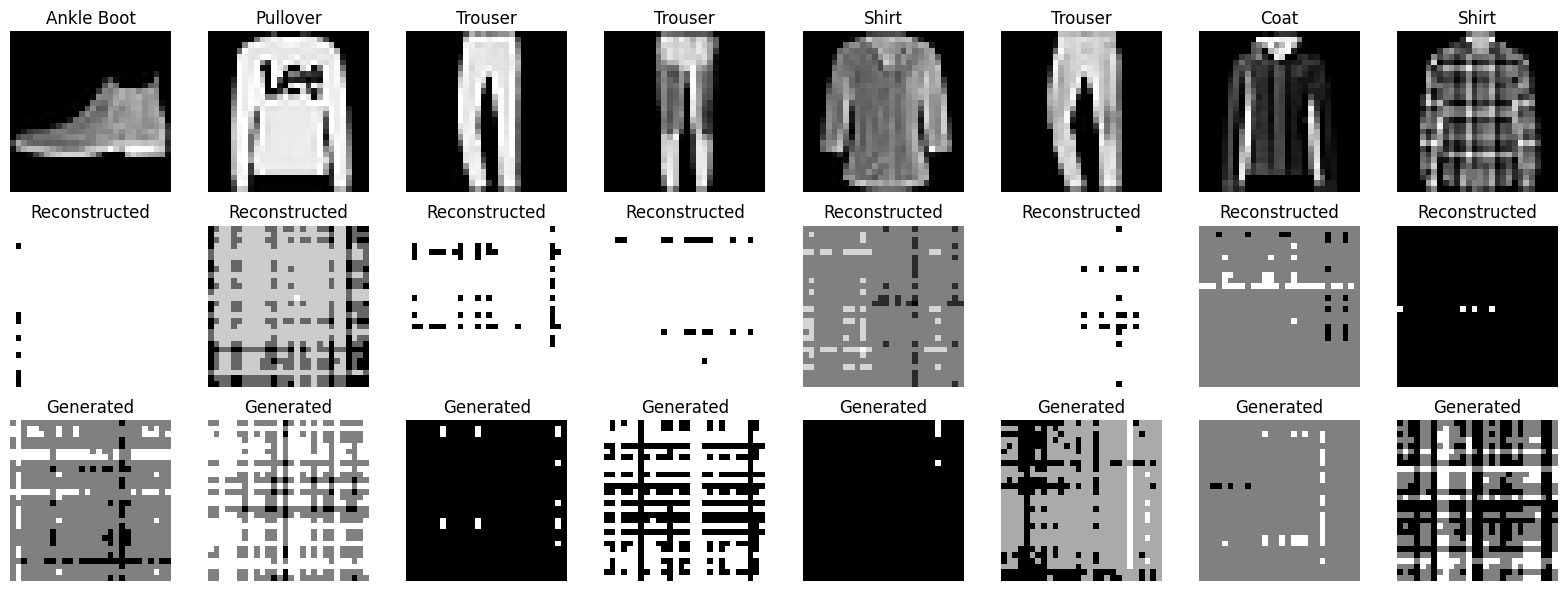

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transform)

batch_size = 16  
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

def positional_encoding(coords, num_bands=8):
    """Apply positional encoding to coordinates with multiple frequency bands."""
    pos_enc = [coords]
    for i in range(num_bands):
        freq = 2.0 ** i
        pos_enc.append(torch.sin(coords * freq * np.pi))
        pos_enc.append(torch.cos(coords * freq * np.pi))
    return torch.cat(pos_enc, dim=-1)

def get_mgrid(sidelen, dim=2, num_bands=8):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)
    coords = [torch.linspace(-1, 1, s) for s in sidelen]
    mesh_coords = torch.meshgrid(*coords, indexing='ij')  
    coords = torch.stack(mesh_coords, dim=-1).reshape(-1, dim)
    return positional_encoding(coords, num_bands)

class SIREN(nn.Module):
    def __init__(self, input_dim=2+2*2*8, hidden_dim=256, hidden_layers=3, output_dim=1, first_omega=1.0, hidden_omega=10.0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.first_omega = first_omega
        self.hidden_omega = hidden_omega

        self.first_layer = nn.Linear(input_dim, hidden_dim)
        with torch.no_grad():

            self.first_layer.weight.uniform_(-1/input_dim, 1/input_dim)
            self.first_layer.bias.uniform_(-1/input_dim, 1/input_dim)
        
        self.hidden_layers_list = nn.ModuleList()
        for _ in range(hidden_layers):
            layer = nn.Linear(hidden_dim, hidden_dim)
            with torch.no_grad():

                layer.weight.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                      np.sqrt(6/hidden_dim)/hidden_omega)
                layer.bias.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                    np.sqrt(6/hidden_dim)/hidden_omega)
            self.hidden_layers_list.append(layer)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        with torch.no_grad():

            self.output_layer.weight.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                              np.sqrt(6/hidden_dim)/hidden_omega)
            self.output_layer.bias.uniform_(-1, 1)
    
    def forward(self, x):
        x = torch.sin(self.first_omega * self.first_layer(x))
        for layer in self.hidden_layers_list:
            x = torch.sin(self.hidden_omega * layer(x))

        return torch.sigmoid(self.output_layer(x))
    
    def set_weights_vector(self, weights_vector):
        """Set all weights from a flattened vector"""
        start_idx = 0
        

        w_size = self.first_layer.weight.numel()
        self.first_layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(self.first_layer.weight.shape)
        start_idx += w_size
        
        b_size = self.first_layer.bias.numel()
        self.first_layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(self.first_layer.bias.shape)
        start_idx += b_size
        

        for layer in self.hidden_layers_list:
            w_size = layer.weight.numel()
            layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(layer.weight.shape)
            start_idx += w_size
            
            b_size = layer.bias.numel()
            layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(layer.bias.shape)
            start_idx += b_size
        

        w_size = self.output_layer.weight.numel()
        self.output_layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(self.output_layer.weight.shape)
        start_idx += w_size
        
        b_size = self.output_layer.bias.numel()
        self.output_layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(self.output_layer.bias.shape)
    
    @staticmethod
    def calc_total_weights(input_dim, hidden_dim, hidden_layers, output_dim):
        """Calculate the total number of weights in the SIREN"""
        total = input_dim * hidden_dim + hidden_dim
        
        total += hidden_layers * (hidden_dim * hidden_dim + hidden_dim)
        
        total += hidden_dim * output_dim + output_dim
        
        return total

class VAE(nn.Module):
    def __init__(self, z_dim=64, siren_config=None):
        super().__init__()
        self.z_dim = z_dim
        
        # Default SIREN config
        self.siren_config = {
            'input_dim': 2 + 2*2*8,  
            'hidden_dim': 128,       
            'hidden_layers': 3,       
            'output_dim': 1
        }
        
        # Update config if provided
        if siren_config is not None:
            self.siren_config.update(siren_config)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),             # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),            # 14x14 -> 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),           # 7x7 -> 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        

        self.fc_mu = nn.Linear(512, z_dim)
        self.fc_logvar = nn.Linear(512, z_dim)
        

        total_weights = SIREN.calc_total_weights(
            input_dim=self.siren_config['input_dim'],
            hidden_dim=self.siren_config['hidden_dim'],
            hidden_layers=self.siren_config['hidden_layers'],
            output_dim=self.siren_config['output_dim']
        )
        

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, total_weights) 
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, -4, 4)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # Modify your VAE's decode method
    def decode(self, z):
        raw_weights = self.decoder(z)
        
        # Split and scale weights for different SIREN layers
        weights_list = []
        start_idx = 0
        
        # First layer weights - needs uniform(-1/in_dim, 1/in_dim)
        in_dim = self.siren_config['input_dim']
        first_w_size = in_dim * self.siren_config['hidden_dim']
        first_b_size = self.siren_config['hidden_dim']
        
        first_w = raw_weights[:, start_idx:start_idx+first_w_size].view(-1, self.siren_config['hidden_dim'], in_dim)
        start_idx += first_w_size
        first_w = torch.tanh(first_w) * (1.0/in_dim)  # Scale to proper range
        weights_list.append(first_w.reshape(-1, first_w_size))
        
        first_b = raw_weights[:, start_idx:start_idx+first_b_size]
        start_idx += first_b_size
        first_b = torch.tanh(first_b) * (1.0/in_dim)  # Scale to proper range
        weights_list.append(first_b)
        
        # Hidden layers - needs scaled by sqrt(6/hidden_dim)/omega
        hidden_dim = self.siren_config['hidden_dim']
        hidden_omega = 30.0
        scale_factor = np.sqrt(6/hidden_dim)/hidden_omega
        
        for _ in range(self.siren_config['hidden_layers']):
            hidden_w_size = hidden_dim * hidden_dim
            hidden_w = raw_weights[:, start_idx:start_idx+hidden_w_size].view(-1, hidden_dim, hidden_dim)
            start_idx += hidden_w_size
            hidden_w = torch.tanh(hidden_w) * scale_factor
            weights_list.append(hidden_w.reshape(-1, hidden_w_size))
            
            hidden_b_size = hidden_dim
            hidden_b = raw_weights[:, start_idx:start_idx+hidden_b_size]
            start_idx += hidden_b_size
            hidden_b = torch.tanh(hidden_b) * scale_factor
            weights_list.append(hidden_b)
        
        # Output layer
        out_dim = self.siren_config['output_dim']
        out_w_size = hidden_dim * out_dim
        out_w = raw_weights[:, start_idx:start_idx+out_w_size].view(-1, out_dim, hidden_dim)
        start_idx += out_w_size
        out_w = torch.tanh(out_w) * scale_factor
        weights_list.append(out_w.reshape(-1, out_w_size))
        
        out_b_size = out_dim
        out_b = raw_weights[:, start_idx:start_idx+out_b_size]
        out_b = torch.tanh(out_b)  # Range (-1, 1) is fine for output bias
        weights_list.append(out_b)
        
        # Concatenate all scaled weights
        return torch.cat(weights_list, dim=1)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def train(num_epochs=1, save_interval=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    

    num_bands = 8
    siren_config = {
        'input_dim': 2 + 2*2*num_bands,
        'hidden_dim': 128, 
        'hidden_layers': 3, 
        'output_dim': 1,
    }
    

    vae = VAE(z_dim=64, siren_config=siren_config).to(device) 
    siren = SIREN(
        input_dim=siren_config['input_dim'],
        hidden_dim=siren_config['hidden_dim'],
        hidden_layers=siren_config['hidden_layers'],
        output_dim=siren_config['output_dim']
    ).to(device)
    
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.0005)
    
    coords = get_mgrid(28, num_bands=num_bands).to(device)

    with torch.no_grad():
        print("Coordinate shape:", coords.shape)
        print("Coordinate min/max:", coords[:, 0].min().item(), coords[:, 0].max().item())
        print("Encoded coordinate shape:", coords.shape)
        
        # Visualize the coordinate grid to make sure it's correct
        coord_grid = coords[:, :2].reshape(28, 28, 2)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(coord_grid[:, :, 0].cpu())
        plt.title("X coordinates")
        plt.subplot(1, 2, 2)
        plt.imshow(coord_grid[:, :, 1].cpu())
        plt.title("Y coordinates")
        plt.savefig("coordinate_grid.png")
        plt.close()
    
    example_data = next(iter(test_loader))
    example_images = example_data[0][:8].to(device)
    
    best_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        vae.train()
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        
        for batch_idx, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images = images.to(device)
            batch_size = images.size(0)
            
            optimizer.zero_grad()
            
            siren_weights_batch, mu, logvar = vae(images)
            
            reconstruction_loss = 0
            
            reconstructed_images = []
            for j in range(batch_size):
                siren.set_weights_vector(siren_weights_batch[j])
                
                reconstructed_image = siren(coords).reshape(1, 1, 28, 28)
                reconstructed_images.append(reconstructed_image)
            
            reconstructed_batch = torch.cat(reconstructed_images, dim=0)
            
            reconstruction_loss = F.mse_loss(reconstructed_batch, images)
            
            loss = reconstruction_loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            

            optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += reconstruction_loss.item()
            

            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}/{len(train_loader)}: "
                      f"Loss: {loss.item():.6f}, "
                      f"Recon: {reconstruction_loss.item():.6f}")
        

        avg_loss = total_loss / len(train_loader)
        avg_recon = total_recon_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {avg_loss:.6f}, "
              f"Recon: {avg_recon:.6f}, ")
        

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0

            torch.save({
                'vae_state_dict': vae.state_dict(),
                'siren_config': siren_config,
                'epoch': epoch,
                'loss': avg_loss
            }, 'best_vae_siren_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        if epoch % save_interval == 0:
            with torch.no_grad():
                vae.eval()
                

                test_recon_images = []
                for i in range(example_images.size(0)):
                    # Encode and decode
                    mu, logvar = vae.encode(example_images[i:i+1])
                    z = vae.reparameterize(mu, logvar)
                    siren_weights = vae.decode(z)
                    
                    # Set weights and get reconstruction
                    siren.set_weights_vector(siren_weights.squeeze(0))
                    recon_image = siren(coords).reshape(1, 28, 28)
                    test_recon_images.append(recon_image)
                
                # Stack the images
                test_recon_images = torch.cat(test_recon_images, dim=0)
                
                # Generate random samples
                z = torch.randn(8, vae.z_dim, device=device)
                generated_images = []
                for i in range(z.size(0)):
                    siren_weights = vae.decode(z[i:i+1])
                    siren.set_weights_vector(siren_weights.squeeze(0))
                    gen_image = siren(coords).reshape(1, 28, 28)
                    generated_images.append(gen_image)
                

                generated_images = torch.cat(generated_images, dim=0)
                

                plt.figure(figsize=(12, 8))
                

                for i in range(8):
                    plt.subplot(3, 8, i + 1)
                    plt.imshow(example_images[i].cpu().squeeze(), cmap='gray')
                    plt.axis('off')
                    plt.title("Original")
                
                for i in range(8):
                    plt.subplot(3, 8, i + 9)
                    plt.imshow(test_recon_images[i].cpu().squeeze(), cmap='gray')
                    plt.axis('off')
                    plt.title("Reconstructed")
                
                # Plot generated images
                for i in range(8):
                    plt.subplot(3, 8, i + 17)
                    plt.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
                    plt.axis('off')
                    plt.title("Generated")
                
                plt.suptitle(f"Epoch {epoch+1}")
                plt.tight_layout()
                plt.savefig(f"vae_siren_epoch_{epoch+1}.png")
                plt.close()
    
    print("Training complete!")
    return vae, siren

def evaluate_model(model_path='best_vae_siren_model.pt'):
    # Load model
    checkpoint = torch.load(model_path)
    siren_config = checkpoint['siren_config']
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    vae = VAE(z_dim=64, siren_config=siren_config).to(device)
    vae.load_state_dict(checkpoint['vae_state_dict'])
    
    siren = SIREN(
        input_dim=siren_config['input_dim'],
        hidden_dim=siren_config['hidden_dim'],
        hidden_layers=siren_config['hidden_layers'],
        output_dim=siren_config['output_dim']
    ).to(device)
    
    coords = get_mgrid(28, num_bands=8).to(device)
    
    example_data = next(iter(test_loader))
    test_images = example_data[0][:8].to(device)
    test_labels = example_data[1][:8]
    
    vae.eval()
    with torch.no_grad():
        reconstructed_images = []
        for i in range(test_images.size(0)):
            mu, logvar = vae.encode(test_images[i:i+1])
            z = vae.reparameterize(mu, logvar)
            siren_weights = vae.decode(z)
            
            siren.set_weights_vector(siren_weights.squeeze(0))
            recon_image = siren(coords).reshape(1, 28, 28)
            reconstructed_images.append(recon_image)
        
        reconstructed_images = torch.cat(reconstructed_images, dim=0)
        
        z = torch.randn(8, vae.z_dim, device=device)
        generated_images = []
        for i in range(z.size(0)):
            siren_weights = vae.decode(z[i:i+1])
            siren.set_weights_vector(siren_weights.squeeze(0))
            gen_image = siren(coords).reshape(1, 28, 28)
            generated_images.append(gen_image)
        
        generated_images = torch.cat(generated_images, dim=0)
    
    fig, axs = plt.subplots(3, 8, figsize=(16, 6))
    
    for i in range(8):
        # Original
        axs[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
        axs[0, i].set_title(f"{class_names[test_labels[i]]}")
        axs[0, i].axis('off')
        
        # Reconstructed
        axs[1, i].imshow(reconstructed_images[i].cpu().squeeze(), cmap='gray')
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis('off')
        
        # Generated
        axs[2, i].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
        axs[2, i].set_title("Generated")
        axs[2, i].axis('off')
    
    plt.tight_layout()
    plt.savefig("evaluation_results.png")
    plt.show()
    
    return vae, siren

if __name__ == "__main__":
    vae, siren = train(num_epochs=1, save_interval=1)
    evaluate_model()

## NEED TO REDUCE WEIGHTS OUTPUT OF VAE, NEED TOO FIX SIREN INIT, NEED TO FIX OUTPUT

# Siren and VAE model (second implementation)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

# Configuration
HIDDEN_SIZE = 64  # Reduced from 128/256
N_HIDDEN_LAYERS = 2  # Reduced from 3
OMEGA_0 = 30.0  # First layer omega
IMAGE_CHANNELS = 1
Z_DIM = 64  # Reduced from 100

# Data Loading with smaller batch size
subset_size = 8000
indices = torch.randperm(len(train_set))[:subset_size]
subset = torch.utils.data.Subset(train_set, indices)

transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transform)

batch_size = 8  
train_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

def positional_encoding(coords, num_bands=4):  # Reduced from 8
    pos_enc = [coords]
    for i in range(num_bands):
        freq = 2.0 ** i
        pos_enc.append(torch.sin(coords * freq * np.pi))
        pos_enc.append(torch.cos(coords * freq * np.pi))
    return torch.cat(pos_enc, dim=-1)

def get_mgrid(sidelen, dim=2, num_bands=4):  # Reduced from 8
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)
    coords = [torch.linspace(-1, 1, s) for s in sidelen]
    mesh_coords = torch.meshgrid(*coords, indexing='ij')  
    coords = torch.stack(mesh_coords, dim=-1).reshape(-1, dim)
    return positional_encoding(coords, num_bands)

class SineLayer(nn.Module):
    """
    Sine layer with dynamically injected weights to maintain gradient flow
    """
    def __init__(self, in_features, out_features, omega_0=OMEGA_0):
        super().__init__()
        self.omega_0 = omega_0
        self.in_features = in_features
        self.out_features = out_features
    
    def forward(self, input, weights):
        """
        weights is a flattened tensor where:
        - First part: weight matrix
        - Second part: bias vector
        """
        weight_size = self.out_features * self.in_features
        
        # Extract weights and bias from the flattened tensor
        W = weights[:weight_size].view(self.out_features, self.in_features)
        b = weights[weight_size:weight_size + self.out_features]
        
        # Apply linear transformation followed by sine activation
        return torch.sin(self.omega_0 * F.linear(input, W, b))

class SIREN(nn.Module):
    """
    SIREN network with dynamically injected weights from generator
    """
    def __init__(self, in_features=2+2*2*4, hidden_size=HIDDEN_SIZE, 
                 n_hidden_layers=N_HIDDEN_LAYERS, output_features=IMAGE_CHANNELS):
        super().__init__()
        self.in_features = in_features
        self.hidden_size = hidden_size
        self.output_features = output_features
        
        # Create sine layers (without weights)
        self.layers = nn.ModuleList()
        self.layers.append(SineLayer(in_features, hidden_size))
        
        for _ in range(n_hidden_layers):
            self.layers.append(SineLayer(hidden_size, hidden_size))
        
        # No parameters in this module - all weights will be passed dynamically
        
        # Calculate total parameter count for generator output size
        self.total_params = (in_features * hidden_size + hidden_size)  # First layer
        self.total_params += n_hidden_layers * (hidden_size * hidden_size + hidden_size)  # Hidden layers
        self.total_params += (hidden_size * output_features + output_features)  # Final layer
    
    def forward(self, x, all_weights):
        """
        Forward pass using dynamically generated weights
        """
        start_idx = 0
        
        # First layer
        first_layer_size = self.hidden_size * self.in_features + self.hidden_size
        x = self.layers[0](x, all_weights[start_idx:start_idx + first_layer_size])
        start_idx += first_layer_size
        
        # Hidden layers
        for layer in self.layers[1:]:
            layer_size = self.hidden_size * self.hidden_size + self.hidden_size
            x = layer(x, all_weights[start_idx:start_idx + layer_size])
            start_idx += layer_size
        
        # Final layer (manually apply linear + sigmoid)
        final_weight_size = self.output_features * self.hidden_size
        W_final = all_weights[start_idx:start_idx + final_weight_size].view(
            self.output_features, self.hidden_size)
        b_final = all_weights[start_idx + final_weight_size:
                             start_idx + final_weight_size + self.output_features]
        
        # Apply final transformation and activation
        x = F.linear(x, W_final, b_final)
        x = torch.sigmoid(x)
        
        return x

class Generator(nn.Module):
    """
    Generator that outputs weights for SIREN network
    """
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        
        # Create SIREN template to get parameter count
        self.siren = SIREN(
            in_features=2+2*2*4,  # Reduced encoding dimensions
            hidden_size=HIDDEN_SIZE,
            n_hidden_layers=N_HIDDEN_LAYERS
        )
        
        # Smaller generator network
        self.gen_net = nn.Sequential(
            nn.Linear(z_dim, 128),  # Reduced from 256
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),    # Reduced from 512
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, self.siren.total_params),
            nn.Tanh()  # Keep weights in a reasonable range
        )
        
    def forward(self, z, grid):
        """
        Generate SIREN weights and images
        """
        # Generate weights for SIREN
        batch_size = z.size(0)
        siren_weights = self.gen_net(z)
        
        # Create images by running SIREN with these weights
        images = []
        for i in range(batch_size):
            # Run SIREN on coordinate grid with generated weights
            pixel_values = self.siren(grid, siren_weights[i])
            
            # Reshape to image dimensions
            image = pixel_values.reshape(28, 28).unsqueeze(0)  # Add channel dimension
            images.append(image)
        
        # Stack all images into a batch
        images = torch.stack(images)
        
        return images, siren_weights

class Discriminator(nn.Module):
    """
    Simplified discriminator network
    """
    def __init__(self):
        super().__init__()
        
        # Smaller discriminator
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),  # Reduced from 512
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),     # Reduced from 0.4
            nn.Linear(256, 128),  # Reduced from 256
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

class GAN(nn.Module):
    """
    GAN model combining generator and discriminator
    """
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        
        self.generator = Generator(z_dim=z_dim)
        self.discriminator = Discriminator()
        self.z_dim = z_dim
    
    def forward(self, z, grid):
        images, _ = self.generator(z, grid)
        return images

In [ ]:
def train(gan, train_loader, grid, num_epochs=5, device="cpu"):
    # Optimizers with adjusted learning rates
    optimizer_g = optim.Adam(gan.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))  # Lower learning rate
    optimizer_d = optim.Adam(gan.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))  # Lower learning rate
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Training stats
    d_losses = []
    g_losses = []
    
    gan.train()
    
    # Use subset of data for faster training
    subset_size = 8000  # Use 8000 samples instead of full 60k
    subset_loader = train_loader
    if len(train_loader.dataset) > subset_size:
        indices = torch.randperm(len(train_loader.dataset))[:subset_size]
        subset = torch.utils.data.Subset(train_loader.dataset, indices)
        subset_loader = torch.utils.data.DataLoader(subset, batch_size=train_loader.batch_size, shuffle=True)
    
    # Label smoothing
    real_target = 0.9  # Use 0.9 instead of 1.0 for real labels
    
    for epoch in range(num_epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0
        batch_count = 0
        
        for real_images, _ in tqdm(subset_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            batch_count += 1
            
            # Labels with noise for label smoothing
            real_labels = torch.ones(batch_size, 1).to(device) * real_target
            real_labels += 0.05 * torch.rand(batch_size, 1).to(device)  # Add noise
            fake_labels = torch.zeros(batch_size, 1).to(device)
            fake_labels += 0.05 * torch.rand(batch_size, 1).to(device)  # Add noise
            
            # ---------------------
            # Train Discriminator
            # ---------------------
            for _ in range(1):  # Optionally train D more than G
                optimizer_d.zero_grad()
                
                # Real images
                d_real = gan.discriminator(real_images)
                d_real_loss = criterion(d_real, real_labels)
                
                # Fake images
                z = torch.randn(batch_size, gan.z_dim).to(device)
                z = z * 0.5  # Reduce noise magnitude
                fake_images, _ = gan.generator(z, grid)
                
                # Add noise to images occasionally to reduce overfitting
                if np.random.random() < 0.1:
                    fake_images = fake_images + 0.05 * torch.randn_like(fake_images).to(device)
                    fake_images = torch.clamp(fake_images, 0, 1)  # Keep in valid range
                
                d_fake = gan.discriminator(fake_images.detach())
                d_fake_loss = criterion(d_fake, fake_labels)
                
                # Combined loss and backprop
                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(gan.discriminator.parameters(), 1.0)
                
                optimizer_d.step()
            
            # Only train generator if discriminator is performing reasonably well
            d_acc = ((d_real > 0.5).float().mean() + (d_fake < 0.5).float().mean()) / 2
            
            # ---------------------
            # Train Generator
            # ---------------------
            if d_acc > 0.6:  # Only train G if D is performing well
                for _ in range(1):  # Train once by default
                    optimizer_g.zero_grad()
                    
                    # Generate new batch of fake images
                    z = torch.randn(batch_size, gan.z_dim).to(device)
                    z = z * 0.5  # Reduce noise magnitude
                    fake_images, _ = gan.generator(z, grid)
                    
                    # Generate output from discriminator
                    d_fake = gan.discriminator(fake_images)
                    
                    # Use the standard GAN loss
                    g_loss = criterion(d_fake, real_labels)
                    
                    # Backprop
                    g_loss.backward()
                    
                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_(gan.generator.parameters(), 1.0)
                    
                    optimizer_g.step()
            else:
                # If discriminator is too good, just record loss but don't train
                d_fake = gan.discriminator(fake_images)
                g_loss = criterion(d_fake, real_labels)
            
            # Record losses
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            
            # Print batch stats occasionally
            if batch_count % 50 == 0:
                d_real_mean = d_real.mean().item()
                d_fake_mean = d_fake.mean().item()
                print(f"Batch {batch_count}: D_real: {d_real_mean:.4f}, D_fake: {d_fake_mean:.4f}, D_acc: {d_acc:.4f}")
            
        # Calculate average losses for this epoch
        epoch_d_loss /= batch_count
        epoch_g_loss /= batch_count
        
        # Save losses for plotting
        d_losses.append(epoch_d_loss)
        g_losses.append(epoch_g_loss)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - D Loss: {epoch_d_loss:.4f}, G Loss: {epoch_g_loss:.4f}")
        
        # Visualize sample images
        if epoch % 1 == 0:
            visualize_samples(gan, real_images, fake_images, device)
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Losses')
    plt.show()
    
    return gan, d_losses, g_losses

def visualize_samples(gan, real_images, fake_images, device, num_examples=4):
    """Visualize real and generated samples"""
    plt.figure(figsize=(10, 4))
    
    # Show real images
    for i in range(min(num_examples, len(real_images))):
        plt.subplot(2, num_examples, i+1)
        plt.imshow(real_images[i].detach().cpu().squeeze(0), cmap="gray")
        plt.title("Real")
        plt.axis("off")
    
    # Show fake images
    for i in range(min(num_examples, len(fake_images))):
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(fake_images[i].detach().cpu().squeeze(0), cmap="gray")
        plt.title("Generated")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Main executio

Using device: cpu


Epoch 1/3:   5%|▌         | 51/1000 [00:06<01:47,  8.82it/s]

Batch 50: D_real: 0.7351, D_fake: 0.0842, D_acc: 1.0000


Epoch 1/3:  10%|█         | 100/1000 [00:14<03:03,  4.90it/s]

Batch 100: D_real: 0.8844, D_fake: 0.0322, D_acc: 1.0000


Epoch 1/3:  15%|█▌        | 151/1000 [00:22<01:47,  7.87it/s]

Batch 150: D_real: 0.8891, D_fake: 0.0306, D_acc: 1.0000


Epoch 1/3:  20%|██        | 200/1000 [00:32<02:08,  6.22it/s]

Batch 200: D_real: 0.9165, D_fake: 0.0299, D_acc: 1.0000


Epoch 1/3:  25%|██▌       | 251/1000 [00:39<01:37,  7.72it/s]

Batch 250: D_real: 0.8823, D_fake: 0.0383, D_acc: 1.0000


Epoch 1/3:  30%|███       | 301/1000 [00:45<01:19,  8.81it/s]

Batch 300: D_real: 0.9132, D_fake: 0.0312, D_acc: 1.0000


Epoch 1/3:  35%|███▌      | 351/1000 [00:51<01:57,  5.51it/s]

Batch 350: D_real: 0.8862, D_fake: 0.0302, D_acc: 1.0000


Epoch 1/3:  40%|████      | 401/1000 [00:57<01:02,  9.61it/s]

Batch 400: D_real: 0.9106, D_fake: 0.0362, D_acc: 1.0000


Epoch 1/3:  45%|████▌     | 451/1000 [01:03<01:17,  7.10it/s]

Batch 450: D_real: 0.9079, D_fake: 0.0363, D_acc: 1.0000


Epoch 1/3:  50%|█████     | 501/1000 [01:12<01:43,  4.82it/s]

Batch 500: D_real: 0.8695, D_fake: 0.0233, D_acc: 1.0000


Epoch 1/3:  55%|█████▌    | 551/1000 [01:19<00:48,  9.35it/s]

Batch 550: D_real: 0.9123, D_fake: 0.0297, D_acc: 1.0000


Epoch 1/3:  60%|██████    | 601/1000 [01:24<00:42,  9.47it/s]

Batch 600: D_real: 0.9093, D_fake: 0.0320, D_acc: 1.0000


Epoch 1/3:  65%|██████▌   | 650/1000 [01:30<00:34, 10.25it/s]

Batch 650: D_real: 0.8918, D_fake: 0.0272, D_acc: 1.0000


Epoch 1/3:  70%|███████   | 701/1000 [01:34<00:23, 12.65it/s]

Batch 700: D_real: 0.9148, D_fake: 0.0310, D_acc: 1.0000


Epoch 1/3:  75%|███████▌  | 751/1000 [01:38<00:20, 12.14it/s]

Batch 750: D_real: 0.8572, D_fake: 0.0301, D_acc: 1.0000


Epoch 1/3:  80%|████████  | 801/1000 [01:43<00:15, 12.60it/s]

Batch 800: D_real: 0.9016, D_fake: 0.0237, D_acc: 1.0000


Epoch 1/3:  85%|████████▌ | 851/1000 [01:47<00:12, 12.05it/s]

Batch 850: D_real: 0.9120, D_fake: 0.0324, D_acc: 1.0000


Epoch 1/3:  90%|█████████ | 901/1000 [01:51<00:08, 11.90it/s]

Batch 900: D_real: 0.8951, D_fake: 0.0258, D_acc: 1.0000


Epoch 1/3:  95%|█████████▌| 951/1000 [01:55<00:04, 12.13it/s]

Batch 950: D_real: 0.9270, D_fake: 0.0361, D_acc: 1.0000


Epoch 1/3: 100%|██████████| 1000/1000 [01:59<00:00,  8.34it/s]


Batch 1000: D_real: 0.9313, D_fake: 0.0298, D_acc: 1.0000
Epoch 1/3 - D Loss: 0.4395, G Loss: 3.2553


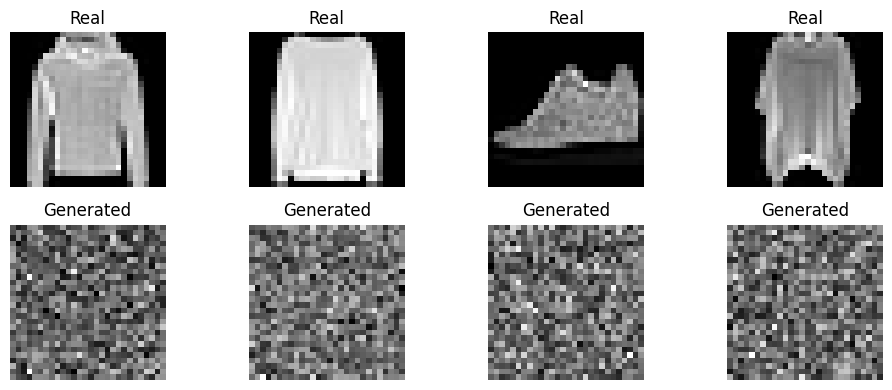

Epoch 2/3:   5%|▌         | 52/1000 [00:04<01:18, 12.06it/s]

Batch 50: D_real: 0.9114, D_fake: 0.0278, D_acc: 1.0000


Epoch 2/3:  10%|█         | 101/1000 [00:09<01:35,  9.40it/s]

Batch 100: D_real: 0.9115, D_fake: 0.0317, D_acc: 1.0000


Epoch 2/3:  15%|█▌        | 151/1000 [00:16<02:00,  7.03it/s]

Batch 150: D_real: 0.9119, D_fake: 0.0230, D_acc: 1.0000


Epoch 2/3:  20%|██        | 201/1000 [00:24<02:31,  5.29it/s]

Batch 200: D_real: 0.9198, D_fake: 0.0292, D_acc: 1.0000


Epoch 2/3:  25%|██▌       | 251/1000 [00:31<01:50,  6.80it/s]

Batch 250: D_real: 0.9037, D_fake: 0.0237, D_acc: 1.0000


Epoch 2/3:  30%|███       | 300/1000 [00:37<01:30,  7.71it/s]

Batch 300: D_real: 0.8707, D_fake: 0.0220, D_acc: 1.0000


Epoch 2/3:  35%|███▌      | 350/1000 [00:44<01:09,  9.29it/s]

Batch 350: D_real: 0.9348, D_fake: 0.0262, D_acc: 1.0000


Epoch 2/3:  40%|████      | 401/1000 [00:50<01:01,  9.69it/s]

Batch 400: D_real: 0.9035, D_fake: 0.0554, D_acc: 1.0000


Epoch 2/3:  45%|████▌     | 452/1000 [00:57<01:01,  8.90it/s]

Batch 450: D_real: 0.9129, D_fake: 0.0326, D_acc: 1.0000


Epoch 2/3:  50%|█████     | 501/1000 [01:04<01:05,  7.61it/s]

Batch 500: D_real: 0.9275, D_fake: 0.0326, D_acc: 1.0000


Epoch 2/3:  55%|█████▌    | 551/1000 [01:10<01:03,  7.08it/s]

Batch 550: D_real: 0.8918, D_fake: 0.0296, D_acc: 1.0000


Epoch 2/3:  60%|██████    | 601/1000 [01:17<00:45,  8.68it/s]

Batch 600: D_real: 0.9281, D_fake: 0.0218, D_acc: 1.0000


Epoch 2/3:  65%|██████▌   | 651/1000 [01:24<00:56,  6.18it/s]

Batch 650: D_real: 0.9115, D_fake: 0.0251, D_acc: 1.0000


Epoch 2/3:  70%|███████   | 701/1000 [01:30<00:31,  9.38it/s]

Batch 700: D_real: 0.9152, D_fake: 0.0224, D_acc: 1.0000


Epoch 2/3:  75%|███████▌  | 751/1000 [01:36<00:28,  8.60it/s]

Batch 750: D_real: 0.9094, D_fake: 0.0230, D_acc: 1.0000


Epoch 2/3:  80%|████████  | 801/1000 [01:44<00:24,  8.12it/s]

Batch 800: D_real: 0.9171, D_fake: 0.0285, D_acc: 1.0000


Epoch 2/3:  85%|████████▌ | 851/1000 [01:49<00:20,  7.10it/s]

Batch 850: D_real: 0.9220, D_fake: 0.0245, D_acc: 1.0000


Epoch 2/3:  90%|█████████ | 901/1000 [01:56<00:13,  7.40it/s]

Batch 900: D_real: 0.9113, D_fake: 0.0257, D_acc: 1.0000


Epoch 2/3:  95%|█████████▌| 951/1000 [02:03<00:06,  8.06it/s]

Batch 950: D_real: 0.9248, D_fake: 0.0181, D_acc: 1.0000


Epoch 2/3: 100%|██████████| 1000/1000 [02:08<00:00,  7.78it/s]


Batch 1000: D_real: 0.9298, D_fake: 0.0301, D_acc: 1.0000
Epoch 2/3 - D Loss: 0.3960, G Loss: 3.4151


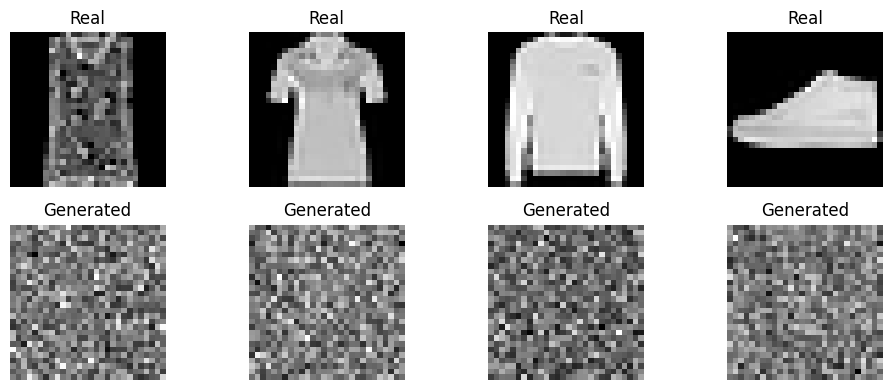

Epoch 3/3:   4%|▎         | 37/1000 [00:04<02:01,  7.91it/s]


KeyboardInterrupt: 

In [27]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create coordinate grid (smaller positional encoding)
    grid = get_mgrid(28, dim=2, num_bands=4).to(device)
    
    # Create GAN
    gan = GAN(z_dim=Z_DIM).to(device)
    
    # Train with standard BCE loss
    gan, d_losses, g_losses = train(gan, train_loader, grid, num_epochs=3, device=device)
    
    # Generate final samples
    gan.eval()
    with torch.no_grad():
        z = torch.randn(8, Z_DIM).to(device)
        generated_images, _ = gan.generator(z, grid)
        
        plt.figure(figsize=(12, 3))
        for i in range(8):
            plt.subplot(1, 8, i+1)
            plt.imshow(generated_images[i].cpu().squeeze(0), cmap="gray")
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()

Using device: cpu


Epoch 1/20:  12%|█▏        | 15/125 [00:00<00:05, 20.59it/s]

  Batch 10: D(real)=0.500, D(fake)=0.476


Epoch 1/20:  19%|█▉        | 24/125 [00:01<00:04, 20.30it/s]

  Batch 20: D(real)=0.494, D(fake)=0.455


Epoch 1/20:  26%|██▋       | 33/125 [00:01<00:04, 20.45it/s]

  Batch 30: D(real)=0.493, D(fake)=0.426


Epoch 1/20:  35%|███▌      | 44/125 [00:02<00:04, 19.95it/s]

  Batch 40: D(real)=0.503, D(fake)=0.404


Epoch 1/20:  42%|████▏     | 52/125 [00:02<00:03, 19.15it/s]

  Batch 50: D(real)=0.508, D(fake)=0.393


Epoch 1/20:  49%|████▉     | 61/125 [00:03<00:04, 13.91it/s]

  Batch 60: D(real)=0.515, D(fake)=0.361


Epoch 1/20:  57%|█████▋    | 71/125 [00:04<00:04, 11.95it/s]

  Batch 70: D(real)=0.548, D(fake)=0.344


Epoch 1/20:  65%|██████▍   | 81/125 [00:05<00:04,  8.82it/s]

  Batch 80: D(real)=0.565, D(fake)=0.316


Epoch 1/20:  74%|███████▍  | 93/125 [00:06<00:02, 12.53it/s]

  Batch 90: D(real)=0.592, D(fake)=0.289


Epoch 1/20:  81%|████████  | 101/125 [00:06<00:01, 15.73it/s]

  Batch 100: D(real)=0.593, D(fake)=0.268


Epoch 1/20:  90%|█████████ | 113/125 [00:07<00:00, 13.52it/s]

  Batch 110: D(real)=0.597, D(fake)=0.241


Epoch 1/20:  98%|█████████▊| 123/125 [00:08<00:00, 15.62it/s]

  Batch 120: D(real)=0.657, D(fake)=0.211


Epoch 1/20: 100%|██████████| 125/125 [00:08<00:00, 14.55it/s]


Epoch 1/20 - D Loss: 1.0821, G Loss: 1.0101


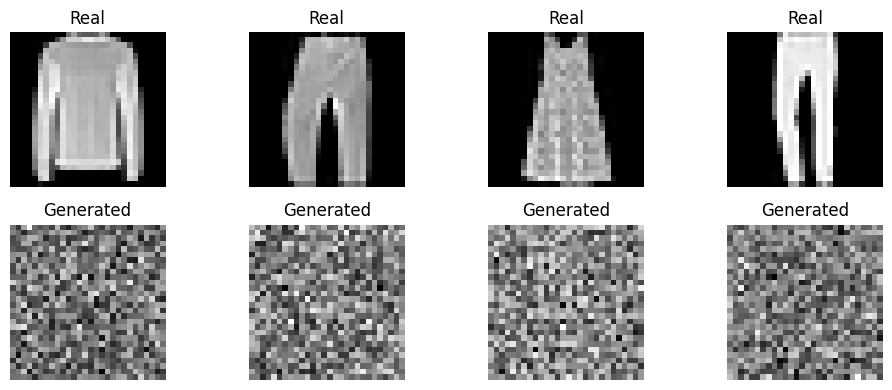

Epoch 2/20:  12%|█▏        | 15/125 [00:00<00:05, 19.57it/s]

  Batch 10: D(real)=0.671, D(fake)=0.177


Epoch 2/20:  18%|█▊        | 23/125 [00:01<00:05, 19.65it/s]

  Batch 20: D(real)=0.640, D(fake)=0.152


Epoch 2/20:  26%|██▌       | 32/125 [00:01<00:05, 16.99it/s]

  Batch 30: D(real)=0.708, D(fake)=0.139


Epoch 2/20:  34%|███▍      | 43/125 [00:02<00:04, 18.39it/s]

  Batch 40: D(real)=0.696, D(fake)=0.118


Epoch 2/20:  42%|████▏     | 52/125 [00:02<00:03, 18.45it/s]

  Batch 50: D(real)=0.692, D(fake)=0.101


Epoch 2/20:  50%|█████     | 63/125 [00:03<00:02, 20.92it/s]

  Batch 60: D(real)=0.758, D(fake)=0.092


Epoch 2/20:  58%|█████▊    | 72/125 [00:03<00:02, 21.65it/s]

  Batch 70: D(real)=0.767, D(fake)=0.086


Epoch 2/20:  67%|██████▋   | 84/125 [00:04<00:01, 22.31it/s]

  Batch 80: D(real)=0.822, D(fake)=0.072


Epoch 2/20:  74%|███████▎  | 92/125 [00:05<00:01, 16.77it/s]

  Batch 90: D(real)=0.791, D(fake)=0.068


Epoch 2/20:  81%|████████  | 101/125 [00:05<00:01, 20.03it/s]

  Batch 100: D(real)=0.798, D(fake)=0.057


Epoch 2/20:  90%|████████▉ | 112/125 [00:06<00:00, 19.32it/s]

  Batch 110: D(real)=0.786, D(fake)=0.053


Epoch 2/20:  99%|█████████▉| 124/125 [00:06<00:00, 21.74it/s]

  Batch 120: D(real)=0.789, D(fake)=0.046


Epoch 2/20: 100%|██████████| 125/125 [00:06<00:00, 18.76it/s]


Epoch 2/20 - D Loss: 0.5361, G Loss: 2.1885


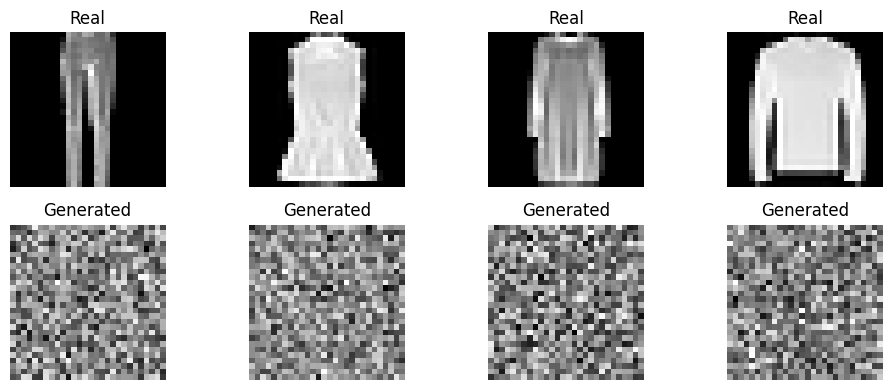

Epoch 3/20:  10%|▉         | 12/125 [00:00<00:05, 20.36it/s]

  Batch 10: D(real)=0.828, D(fake)=0.042


Epoch 3/20:  17%|█▋        | 21/125 [00:01<00:05, 20.16it/s]

  Batch 20: D(real)=0.839, D(fake)=0.041


Epoch 3/20:  26%|██▌       | 32/125 [00:01<00:05, 17.53it/s]

  Batch 30: D(real)=0.824, D(fake)=0.035


Epoch 3/20:  33%|███▎      | 41/125 [00:02<00:05, 15.15it/s]

  Batch 40: D(real)=0.866, D(fake)=0.035


Epoch 3/20:  42%|████▏     | 52/125 [00:03<00:04, 15.95it/s]

  Batch 50: D(real)=0.883, D(fake)=0.040


Epoch 3/20:  50%|████▉     | 62/125 [00:03<00:04, 14.37it/s]

  Batch 60: D(real)=0.916, D(fake)=0.029


Epoch 3/20:  59%|█████▉    | 74/125 [00:04<00:02, 18.39it/s]

  Batch 70: D(real)=0.847, D(fake)=0.031


Epoch 3/20:  66%|██████▋   | 83/125 [00:05<00:02, 18.44it/s]

  Batch 80: D(real)=0.831, D(fake)=0.025


Epoch 3/20:  74%|███████▍  | 93/125 [00:05<00:01, 20.52it/s]

  Batch 90: D(real)=0.834, D(fake)=0.024


Epoch 3/20:  82%|████████▏ | 103/125 [00:06<00:01, 16.80it/s]

  Batch 100: D(real)=0.837, D(fake)=0.021


Epoch 3/20:  90%|████████▉ | 112/125 [00:06<00:00, 14.15it/s]

  Batch 110: D(real)=0.894, D(fake)=0.024


Epoch 3/20:  97%|█████████▋| 121/125 [00:07<00:00, 14.65it/s]

  Batch 120: D(real)=0.888, D(fake)=0.019


Epoch 3/20: 100%|██████████| 125/125 [00:07<00:00, 16.24it/s]


Epoch 3/20 - D Loss: 0.4076, G Loss: 3.1616


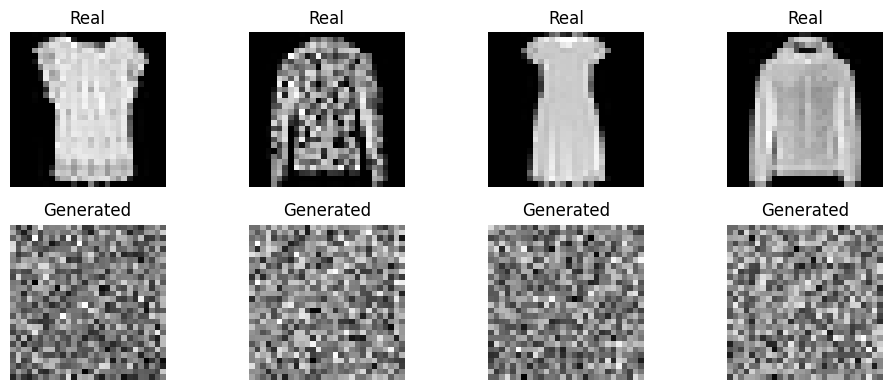

Epoch 4/20:  10%|▉         | 12/125 [00:00<00:08, 14.08it/s]

  Batch 10: D(real)=0.885, D(fake)=0.018


Epoch 4/20:  18%|█▊        | 22/125 [00:01<00:08, 11.60it/s]

  Batch 20: D(real)=0.898, D(fake)=0.018


Epoch 4/20:  26%|██▌       | 32/125 [00:02<00:07, 13.13it/s]

  Batch 30: D(real)=0.879, D(fake)=0.019


Epoch 4/20:  34%|███▎      | 42/125 [00:03<00:06, 13.76it/s]

  Batch 40: D(real)=0.793, D(fake)=0.017


Epoch 4/20:  42%|████▏     | 52/125 [00:04<00:05, 12.65it/s]

  Batch 50: D(real)=0.879, D(fake)=0.016


Epoch 4/20:  50%|████▉     | 62/125 [00:05<00:05, 12.55it/s]

  Batch 60: D(real)=0.886, D(fake)=0.013


Epoch 4/20:  56%|█████▌    | 70/125 [00:05<00:04, 13.29it/s]

  Batch 70: D(real)=0.879, D(fake)=0.015


Epoch 4/20:  66%|██████▌   | 82/125 [00:06<00:03, 12.92it/s]

  Batch 80: D(real)=0.844, D(fake)=0.020


Epoch 4/20:  74%|███████▎  | 92/125 [00:07<00:02, 13.53it/s]

  Batch 90: D(real)=0.853, D(fake)=0.015


Epoch 4/20:  82%|████████▏ | 102/125 [00:08<00:01, 14.65it/s]

  Batch 100: D(real)=0.875, D(fake)=0.016


Epoch 4/20:  90%|████████▉ | 112/125 [00:08<00:00, 15.57it/s]

  Batch 110: D(real)=0.870, D(fake)=0.019


Epoch 4/20:  98%|█████████▊| 122/125 [00:09<00:00, 13.88it/s]

  Batch 120: D(real)=0.852, D(fake)=0.014


Epoch 4/20: 100%|██████████| 125/125 [00:09<00:00, 12.61it/s]


Epoch 4/20 - D Loss: 0.3875, G Loss: 3.7437


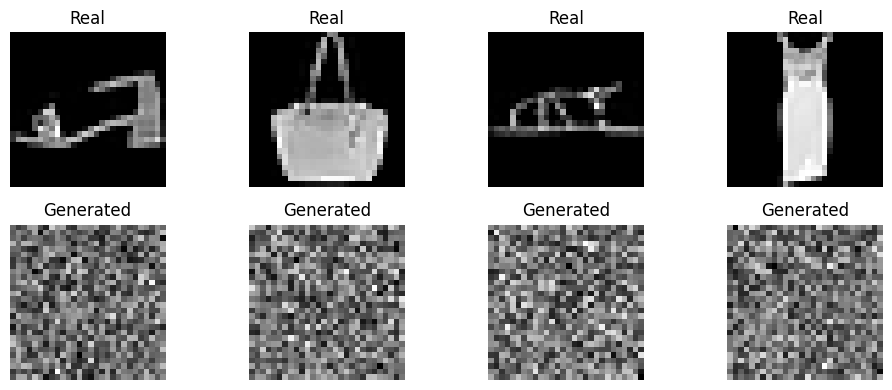

Epoch 5/20:   9%|▉         | 11/125 [00:00<00:06, 18.91it/s]

  Batch 10: D(real)=0.916, D(fake)=0.015


Epoch 5/20:  18%|█▊        | 23/125 [00:01<00:07, 13.48it/s]

  Batch 20: D(real)=0.907, D(fake)=0.013


Epoch 5/20:  26%|██▋       | 33/125 [00:02<00:06, 15.31it/s]

  Batch 30: D(real)=0.844, D(fake)=0.017


Epoch 5/20:  34%|███▍      | 43/125 [00:02<00:04, 16.65it/s]

  Batch 40: D(real)=0.844, D(fake)=0.014


Epoch 5/20:  42%|████▏     | 53/125 [00:03<00:04, 16.82it/s]

  Batch 50: D(real)=0.842, D(fake)=0.012


Epoch 5/20:  50%|█████     | 63/125 [00:03<00:03, 18.67it/s]

  Batch 60: D(real)=0.864, D(fake)=0.012


Epoch 5/20:  58%|█████▊    | 73/125 [00:04<00:02, 20.40it/s]

  Batch 70: D(real)=0.796, D(fake)=0.010


Epoch 5/20:  66%|██████▌   | 82/125 [00:04<00:02, 20.68it/s]

  Batch 80: D(real)=0.869, D(fake)=0.011


Epoch 5/20:  74%|███████▍  | 93/125 [00:05<00:01, 18.33it/s]

  Batch 90: D(real)=0.874, D(fake)=0.010


Epoch 5/20:  82%|████████▏ | 102/125 [00:06<00:01, 13.68it/s]

  Batch 100: D(real)=0.874, D(fake)=0.013


Epoch 5/20:  89%|████████▉ | 111/125 [00:06<00:00, 17.58it/s]

  Batch 110: D(real)=0.871, D(fake)=0.010


Epoch 5/20:  99%|█████████▉| 124/125 [00:07<00:00, 19.25it/s]

  Batch 120: D(real)=0.883, D(fake)=0.009


Epoch 5/20: 100%|██████████| 125/125 [00:07<00:00, 16.58it/s]


Epoch 5/20 - D Loss: 0.3781, G Loss: 4.0279


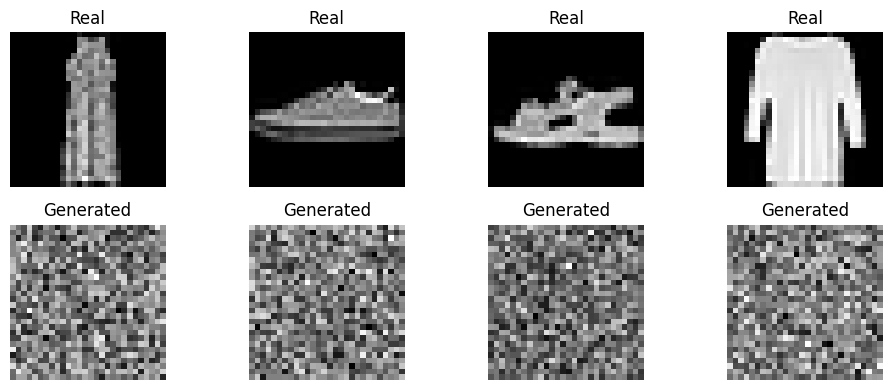

Epoch 6/20:   9%|▉         | 11/125 [00:00<00:07, 15.71it/s]

  Batch 10: D(real)=0.877, D(fake)=0.012


Epoch 6/20:  18%|█▊        | 23/125 [00:01<00:05, 17.80it/s]

  Batch 20: D(real)=0.850, D(fake)=0.012


Epoch 6/20:  26%|██▋       | 33/125 [00:01<00:05, 16.02it/s]

  Batch 30: D(real)=0.910, D(fake)=0.011


Epoch 6/20:  34%|███▍      | 43/125 [00:02<00:04, 18.22it/s]

  Batch 40: D(real)=0.834, D(fake)=0.010


Epoch 6/20:  42%|████▏     | 53/125 [00:03<00:04, 14.79it/s]

  Batch 50: D(real)=0.843, D(fake)=0.008


Epoch 6/20:  49%|████▉     | 61/125 [00:03<00:04, 14.10it/s]

  Batch 60: D(real)=0.881, D(fake)=0.007


Epoch 6/20:  58%|█████▊    | 72/125 [00:04<00:03, 15.43it/s]

  Batch 70: D(real)=0.812, D(fake)=0.007


Epoch 6/20:  67%|██████▋   | 84/125 [00:05<00:02, 16.20it/s]

  Batch 80: D(real)=0.849, D(fake)=0.010


Epoch 6/20:  75%|███████▌  | 94/125 [00:06<00:01, 19.09it/s]

  Batch 90: D(real)=0.856, D(fake)=0.008


Epoch 6/20:  82%|████████▏ | 102/125 [00:06<00:01, 15.99it/s]

  Batch 100: D(real)=0.858, D(fake)=0.008


Epoch 6/20:  91%|█████████ | 114/125 [00:07<00:00, 21.13it/s]

  Batch 110: D(real)=0.888, D(fake)=0.008


Epoch 6/20: 100%|██████████| 125/125 [00:07<00:00, 16.56it/s]

  Batch 120: D(real)=0.816, D(fake)=0.008
Epoch 6/20 - D Loss: 0.3722, G Loss: 4.3080


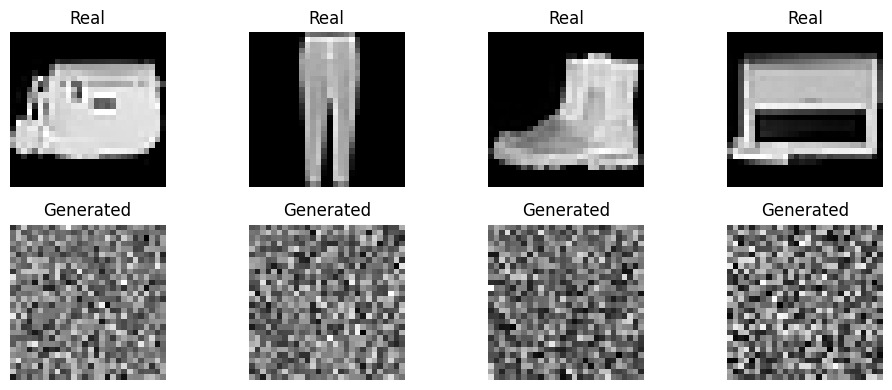

Epoch 7/20:  10%|▉         | 12/125 [00:00<00:05, 21.93it/s]

  Batch 10: D(real)=0.870, D(fake)=0.011


Epoch 7/20:  19%|█▉        | 24/125 [00:01<00:04, 22.48it/s]

  Batch 20: D(real)=0.896, D(fake)=0.010


Epoch 7/20:  26%|██▋       | 33/125 [00:01<00:03, 25.61it/s]

  Batch 30: D(real)=0.890, D(fake)=0.008


Epoch 7/20:  37%|███▋      | 46/125 [00:01<00:02, 28.53it/s]

  Batch 40: D(real)=0.884, D(fake)=0.007


Epoch 7/20:  45%|████▍     | 56/125 [00:02<00:02, 26.21it/s]

  Batch 50: D(real)=0.845, D(fake)=0.007


Epoch 7/20:  54%|█████▎    | 67/125 [00:02<00:01, 31.26it/s]

  Batch 60: D(real)=0.899, D(fake)=0.007


Epoch 7/20:  60%|██████    | 75/125 [00:02<00:01, 32.57it/s]

  Batch 70: D(real)=0.838, D(fake)=0.006


Epoch 7/20:  66%|██████▋   | 83/125 [00:03<00:01, 31.71it/s]

  Batch 80: D(real)=0.822, D(fake)=0.006


Epoch 7/20:  76%|███████▌  | 95/125 [00:03<00:00, 34.99it/s]

  Batch 90: D(real)=0.862, D(fake)=0.006


Epoch 7/20:  86%|████████▌ | 107/125 [00:03<00:00, 34.77it/s]

  Batch 100: D(real)=0.912, D(fake)=0.011


Epoch 7/20:  92%|█████████▏| 115/125 [00:04<00:00, 35.71it/s]

  Batch 110: D(real)=0.875, D(fake)=0.007


Epoch 7/20: 100%|██████████| 125/125 [00:04<00:00, 28.04it/s]

  Batch 120: D(real)=0.882, D(fake)=0.007
Epoch 7/20 - D Loss: 0.3683, G Loss: 4.4509


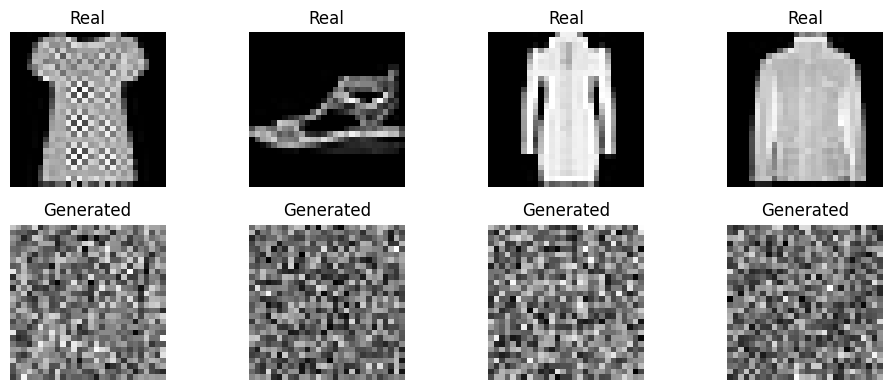

Epoch 8/20:  10%|▉         | 12/125 [00:00<00:03, 32.10it/s]

  Batch 10: D(real)=0.893, D(fake)=0.007


Epoch 8/20:  19%|█▉        | 24/125 [00:00<00:03, 29.77it/s]

  Batch 20: D(real)=0.912, D(fake)=0.006


Epoch 8/20:  26%|██▋       | 33/125 [00:01<00:03, 28.31it/s]

  Batch 30: D(real)=0.883, D(fake)=0.007


Epoch 8/20:  36%|███▌      | 45/125 [00:01<00:03, 26.41it/s]

  Batch 40: D(real)=0.853, D(fake)=0.007


Epoch 8/20:  43%|████▎     | 54/125 [00:01<00:02, 26.84it/s]

  Batch 50: D(real)=0.882, D(fake)=0.006


Epoch 8/20:  50%|█████     | 63/125 [00:02<00:02, 26.63it/s]

  Batch 60: D(real)=0.847, D(fake)=0.006


Epoch 8/20:  58%|█████▊    | 73/125 [00:02<00:02, 23.64it/s]

  Batch 70: D(real)=0.862, D(fake)=0.007


Epoch 8/20:  66%|██████▋   | 83/125 [00:03<00:01, 27.24it/s]

  Batch 80: D(real)=0.889, D(fake)=0.007


Epoch 8/20:  74%|███████▍  | 93/125 [00:03<00:01, 29.35it/s]

  Batch 90: D(real)=0.864, D(fake)=0.007


Epoch 8/20:  82%|████████▏ | 103/125 [00:03<00:00, 26.40it/s]

  Batch 100: D(real)=0.903, D(fake)=0.007


Epoch 8/20:  92%|█████████▏| 115/125 [00:04<00:00, 27.25it/s]

  Batch 110: D(real)=0.899, D(fake)=0.006


Epoch 8/20: 100%|██████████| 125/125 [00:04<00:00, 26.13it/s]

  Batch 120: D(real)=0.820, D(fake)=0.005
Epoch 8/20 - D Loss: 0.3633, G Loss: 4.5785


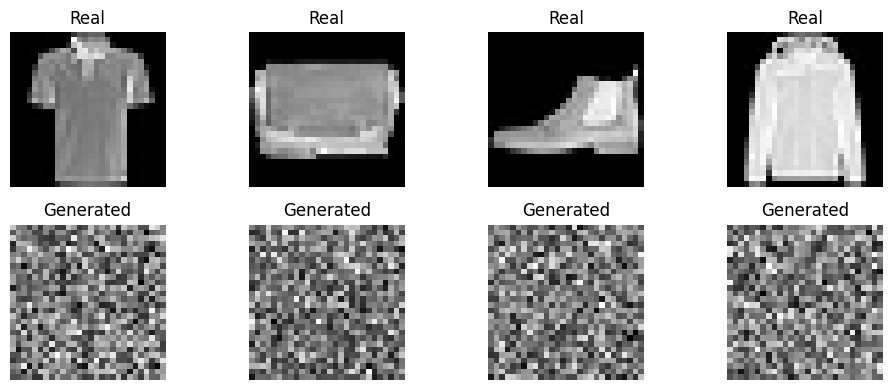

Epoch 9/20:  12%|█▏        | 15/125 [00:00<00:05, 19.92it/s]

  Batch 10: D(real)=0.852, D(fake)=0.005


Epoch 9/20:  18%|█▊        | 22/125 [00:01<00:06, 15.39it/s]

  Batch 20: D(real)=0.897, D(fake)=0.007


Epoch 9/20:  26%|██▌       | 32/125 [00:02<00:07, 12.97it/s]

  Batch 30: D(real)=0.841, D(fake)=0.006


Epoch 9/20:  32%|███▏      | 40/125 [00:02<00:06, 12.63it/s]

  Batch 40: D(real)=0.893, D(fake)=0.007


Epoch 9/20:  42%|████▏     | 52/125 [00:03<00:05, 13.75it/s]

  Batch 50: D(real)=0.862, D(fake)=0.006


Epoch 9/20:  50%|████▉     | 62/125 [00:04<00:04, 13.82it/s]

  Batch 60: D(real)=0.854, D(fake)=0.005


Epoch 9/20:  58%|█████▊    | 73/125 [00:05<00:03, 15.78it/s]

  Batch 70: D(real)=0.883, D(fake)=0.005


Epoch 9/20:  66%|██████▋   | 83/125 [00:05<00:01, 23.67it/s]

  Batch 80: D(real)=0.890, D(fake)=0.005


Epoch 9/20:  75%|███████▌  | 94/125 [00:06<00:01, 28.48it/s]

  Batch 90: D(real)=0.852, D(fake)=0.005


Epoch 9/20:  82%|████████▏ | 102/125 [00:07<00:02, 11.13it/s]

  Batch 100: D(real)=0.899, D(fake)=0.007


Epoch 9/20:  90%|████████▉ | 112/125 [00:08<00:01, 12.35it/s]

  Batch 110: D(real)=0.892, D(fake)=0.006


Epoch 9/20:  98%|█████████▊| 122/125 [00:08<00:00, 13.90it/s]

  Batch 120: D(real)=0.855, D(fake)=0.004


Epoch 9/20: 100%|██████████| 125/125 [00:09<00:00, 13.78it/s]


Epoch 9/20 - D Loss: 0.3599, G Loss: 4.7346


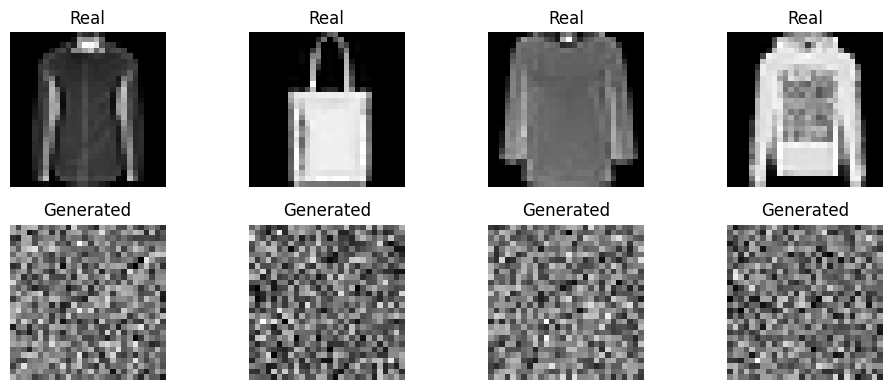

Epoch 10/20:  10%|█         | 13/125 [00:00<00:04, 25.01it/s]

  Batch 10: D(real)=0.859, D(fake)=0.004


Epoch 10/20:  18%|█▊        | 23/125 [00:00<00:04, 23.08it/s]

  Batch 20: D(real)=0.846, D(fake)=0.005


Epoch 10/20:  26%|██▌       | 32/125 [00:01<00:04, 22.55it/s]

  Batch 30: D(real)=0.915, D(fake)=0.006


Epoch 10/20:  33%|███▎      | 41/125 [00:02<00:06, 12.66it/s]

  Batch 40: D(real)=0.872, D(fake)=0.005


Epoch 10/20:  41%|████      | 51/125 [00:03<00:06, 12.01it/s]

  Batch 50: D(real)=0.872, D(fake)=0.006


Epoch 10/20:  50%|████▉     | 62/125 [00:04<00:04, 14.33it/s]

  Batch 60: D(real)=0.891, D(fake)=0.006


Epoch 10/20:  58%|█████▊    | 72/125 [00:04<00:03, 14.60it/s]

  Batch 70: D(real)=0.879, D(fake)=0.005


Epoch 10/20:  66%|██████▋   | 83/125 [00:05<00:02, 16.25it/s]

  Batch 80: D(real)=0.892, D(fake)=0.005


Epoch 10/20:  74%|███████▍  | 93/125 [00:06<00:01, 17.05it/s]

  Batch 90: D(real)=0.860, D(fake)=0.004


Epoch 10/20:  81%|████████  | 101/125 [00:06<00:01, 14.37it/s]

  Batch 100: D(real)=0.862, D(fake)=0.003


Epoch 10/20:  91%|█████████ | 114/125 [00:07<00:00, 16.58it/s]

  Batch 110: D(real)=0.885, D(fake)=0.004


Epoch 10/20:  98%|█████████▊| 122/125 [00:09<00:00,  7.17it/s]

  Batch 120: D(real)=0.889, D(fake)=0.004


Epoch 10/20: 100%|██████████| 125/125 [00:09<00:00, 13.42it/s]


Epoch 10/20 - D Loss: 0.3574, G Loss: 4.8445


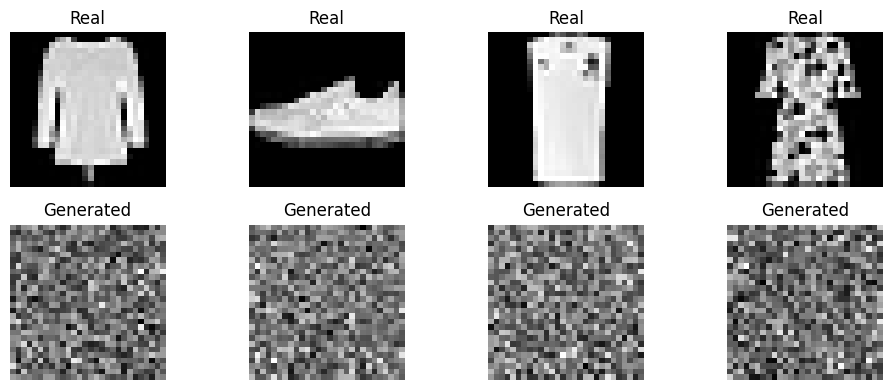

Epoch 11/20:   8%|▊         | 10/125 [00:00<00:09, 12.60it/s]

  Batch 10: D(real)=0.867, D(fake)=0.005


Epoch 11/20:  18%|█▊        | 22/125 [00:01<00:07, 14.11it/s]

  Batch 20: D(real)=0.904, D(fake)=0.005


Epoch 11/20:  26%|██▌       | 32/125 [00:02<00:06, 13.95it/s]

  Batch 30: D(real)=0.871, D(fake)=0.004


Epoch 11/20:  35%|███▌      | 44/125 [00:03<00:05, 14.76it/s]

  Batch 40: D(real)=0.841, D(fake)=0.005


Epoch 11/20:  42%|████▏     | 52/125 [00:03<00:04, 16.38it/s]

  Batch 50: D(real)=0.886, D(fake)=0.005


Epoch 11/20:  50%|█████     | 63/125 [00:04<00:03, 19.65it/s]

  Batch 60: D(real)=0.897, D(fake)=0.004


Epoch 11/20:  58%|█████▊    | 73/125 [00:04<00:02, 25.28it/s]

  Batch 70: D(real)=0.904, D(fake)=0.005


Epoch 11/20:  66%|██████▋   | 83/125 [00:05<00:01, 23.61it/s]

  Batch 80: D(real)=0.842, D(fake)=0.005


Epoch 11/20:  74%|███████▎  | 92/125 [00:05<00:01, 25.16it/s]

  Batch 90: D(real)=0.889, D(fake)=0.004


Epoch 11/20:  83%|████████▎ | 104/125 [00:06<00:01, 17.51it/s]

  Batch 100: D(real)=0.884, D(fake)=0.004


Epoch 11/20:  89%|████████▉ | 111/125 [00:07<00:01, 11.80it/s]

  Batch 110: D(real)=0.903, D(fake)=0.004


Epoch 11/20:  97%|█████████▋| 121/125 [00:08<00:00,  9.29it/s]

  Batch 120: D(real)=0.858, D(fake)=0.004


Epoch 11/20: 100%|██████████| 125/125 [00:09<00:00, 13.26it/s]


Epoch 11/20 - D Loss: 0.3546, G Loss: 4.9858


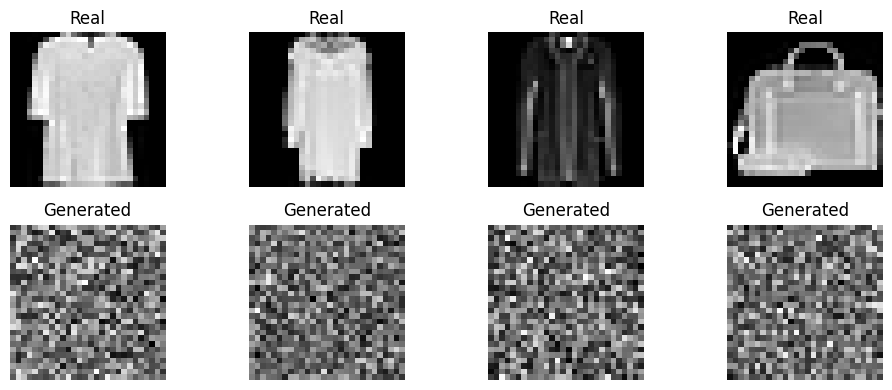

Epoch 12/20:   8%|▊         | 10/125 [00:01<00:16,  7.17it/s]

  Batch 10: D(real)=0.867, D(fake)=0.004


Epoch 12/20:  18%|█▊        | 23/125 [00:03<00:10, 10.16it/s]

  Batch 20: D(real)=0.861, D(fake)=0.004


Epoch 12/20:  26%|██▋       | 33/125 [00:04<00:07, 13.05it/s]

  Batch 30: D(real)=0.880, D(fake)=0.004


Epoch 12/20:  37%|███▋      | 46/125 [00:04<00:03, 19.78it/s]

  Batch 40: D(real)=0.903, D(fake)=0.003


Epoch 12/20:  44%|████▍     | 55/125 [00:05<00:02, 24.00it/s]

  Batch 50: D(real)=0.877, D(fake)=0.004


Epoch 12/20:  52%|█████▏    | 65/125 [00:05<00:02, 24.12it/s]

  Batch 60: D(real)=0.879, D(fake)=0.004


Epoch 12/20:  59%|█████▉    | 74/125 [00:06<00:02, 22.27it/s]

  Batch 70: D(real)=0.889, D(fake)=0.003


Epoch 12/20:  66%|██████▋   | 83/125 [00:06<00:02, 20.02it/s]

  Batch 80: D(real)=0.852, D(fake)=0.004


Epoch 12/20:  74%|███████▎  | 92/125 [00:06<00:01, 22.20it/s]

  Batch 90: D(real)=0.912, D(fake)=0.004


Epoch 12/20:  82%|████████▏ | 102/125 [00:07<00:00, 24.30it/s]

  Batch 100: D(real)=0.885, D(fake)=0.003


Epoch 12/20:  89%|████████▉ | 111/125 [00:07<00:00, 16.95it/s]

  Batch 110: D(real)=0.877, D(fake)=0.003


Epoch 12/20:  98%|█████████▊| 123/125 [00:08<00:00, 20.94it/s]

  Batch 120: D(real)=0.869, D(fake)=0.004


Epoch 12/20: 100%|██████████| 125/125 [00:08<00:00, 14.55it/s]


Epoch 12/20 - D Loss: 0.3528, G Loss: 5.1274


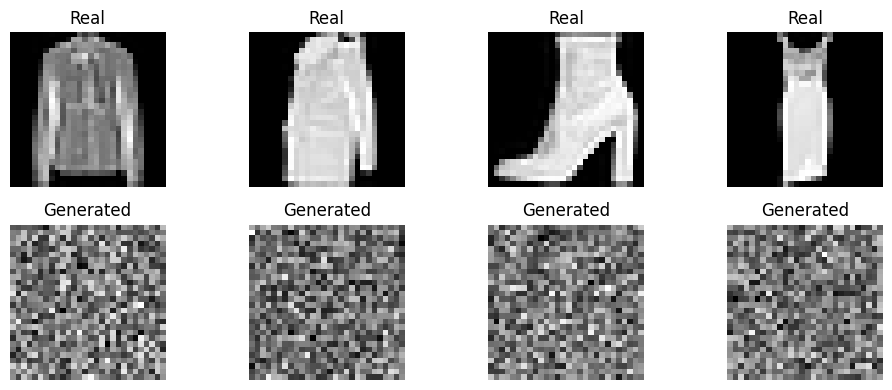

Epoch 13/20:  10%|▉         | 12/125 [00:00<00:05, 22.37it/s]

  Batch 10: D(real)=0.898, D(fake)=0.004


Epoch 13/20:  18%|█▊        | 22/125 [00:00<00:04, 21.72it/s]

  Batch 20: D(real)=0.885, D(fake)=0.004


Epoch 13/20:  25%|██▍       | 31/125 [00:01<00:04, 19.60it/s]

  Batch 30: D(real)=0.885, D(fake)=0.003


Epoch 13/20:  34%|███▍      | 43/125 [00:02<00:03, 21.84it/s]

  Batch 40: D(real)=0.865, D(fake)=0.003


Epoch 13/20:  41%|████      | 51/125 [00:02<00:06, 11.79it/s]

  Batch 50: D(real)=0.846, D(fake)=0.003


Epoch 13/20:  48%|████▊     | 60/125 [00:03<00:05, 12.73it/s]

  Batch 60: D(real)=0.914, D(fake)=0.003


Epoch 13/20:  58%|█████▊    | 72/125 [00:05<00:07,  7.29it/s]

  Batch 70: D(real)=0.849, D(fake)=0.003


Epoch 13/20:  65%|██████▍   | 81/125 [00:06<00:05,  8.07it/s]

  Batch 80: D(real)=0.900, D(fake)=0.004


Epoch 13/20:  74%|███████▍  | 93/125 [00:07<00:02, 13.75it/s]

  Batch 90: D(real)=0.894, D(fake)=0.005


Epoch 13/20:  81%|████████  | 101/125 [00:08<00:01, 14.17it/s]

  Batch 100: D(real)=0.890, D(fake)=0.004


Epoch 13/20:  90%|█████████ | 113/125 [00:09<00:00, 12.04it/s]

  Batch 110: D(real)=0.824, D(fake)=0.002


Epoch 13/20:  98%|█████████▊| 123/125 [00:10<00:00, 12.58it/s]

  Batch 120: D(real)=0.868, D(fake)=0.002


Epoch 13/20: 100%|██████████| 125/125 [00:10<00:00, 11.96it/s]


Epoch 13/20 - D Loss: 0.3517, G Loss: 5.2179


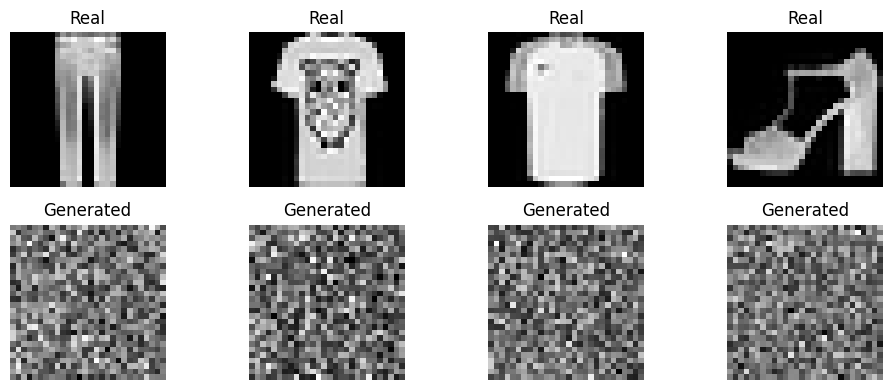

Epoch 14/20:  12%|█▏        | 15/125 [00:00<00:03, 29.93it/s]

  Batch 10: D(real)=0.871, D(fake)=0.003


Epoch 14/20:  20%|██        | 25/125 [00:00<00:03, 28.56it/s]

  Batch 20: D(real)=0.907, D(fake)=0.003


Epoch 14/20:  28%|██▊       | 35/125 [00:01<00:03, 29.65it/s]

  Batch 30: D(real)=0.904, D(fake)=0.002


Epoch 14/20:  36%|███▌      | 45/125 [00:01<00:02, 30.04it/s]

  Batch 40: D(real)=0.894, D(fake)=0.002


Epoch 14/20:  44%|████▍     | 55/125 [00:01<00:02, 29.99it/s]

  Batch 50: D(real)=0.820, D(fake)=0.002


Epoch 14/20:  52%|█████▏    | 65/125 [00:02<00:02, 25.41it/s]

  Batch 60: D(real)=0.870, D(fake)=0.003


Epoch 14/20:  60%|██████    | 75/125 [00:02<00:01, 26.66it/s]

  Batch 70: D(real)=0.873, D(fake)=0.003


Epoch 14/20:  68%|██████▊   | 85/125 [00:03<00:01, 28.53it/s]

  Batch 80: D(real)=0.896, D(fake)=0.003


Epoch 14/20:  76%|███████▌  | 95/125 [00:03<00:01, 28.90it/s]

  Batch 90: D(real)=0.862, D(fake)=0.004


Epoch 14/20:  81%|████████  | 101/125 [00:03<00:00, 27.44it/s]

  Batch 100: D(real)=0.817, D(fake)=0.002


Epoch 14/20:  93%|█████████▎| 116/125 [00:04<00:00, 26.57it/s]

  Batch 110: D(real)=0.886, D(fake)=0.002


Epoch 14/20: 100%|██████████| 125/125 [00:04<00:00, 26.95it/s]

  Batch 120: D(real)=0.858, D(fake)=0.003
Epoch 14/20 - D Loss: 0.3497, G Loss: 5.4139


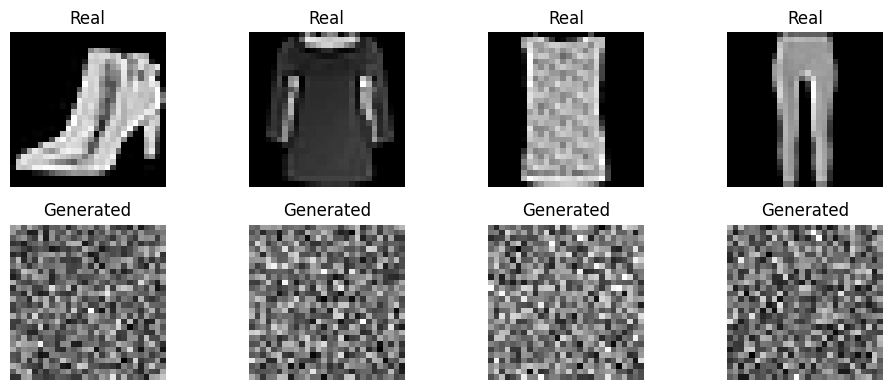

Epoch 15/20:  12%|█▏        | 15/125 [00:00<00:03, 32.93it/s]

  Batch 10: D(real)=0.864, D(fake)=0.003


Epoch 15/20:  18%|█▊        | 23/125 [00:00<00:03, 30.07it/s]

  Batch 20: D(real)=0.866, D(fake)=0.002


Epoch 15/20:  27%|██▋       | 34/125 [00:01<00:03, 29.14it/s]

  Batch 30: D(real)=0.898, D(fake)=0.002


Epoch 15/20:  35%|███▌      | 44/125 [00:01<00:02, 29.53it/s]

  Batch 40: D(real)=0.867, D(fake)=0.002


Epoch 15/20:  44%|████▍     | 55/125 [00:01<00:02, 24.39it/s]

  Batch 50: D(real)=0.900, D(fake)=0.004


Epoch 15/20:  52%|█████▏    | 65/125 [00:02<00:02, 28.30it/s]

  Batch 60: D(real)=0.874, D(fake)=0.002


Epoch 15/20:  60%|██████    | 75/125 [00:02<00:01, 29.48it/s]

  Batch 70: D(real)=0.896, D(fake)=0.003


Epoch 15/20:  68%|██████▊   | 85/125 [00:02<00:01, 30.82it/s]

  Batch 80: D(real)=0.897, D(fake)=0.003


Epoch 15/20:  74%|███████▍  | 93/125 [00:03<00:01, 30.33it/s]

  Batch 90: D(real)=0.891, D(fake)=0.003


Epoch 15/20:  84%|████████▍ | 105/125 [00:03<00:00, 29.90it/s]

  Batch 100: D(real)=0.871, D(fake)=0.003


Epoch 15/20:  93%|█████████▎| 116/125 [00:04<00:00, 30.17it/s]

  Batch 110: D(real)=0.883, D(fake)=0.003


Epoch 15/20:  98%|█████████▊| 123/125 [00:04<00:00, 29.01it/s]

  Batch 120: D(real)=0.874, D(fake)=0.003


Epoch 15/20: 100%|██████████| 125/125 [00:04<00:00, 28.13it/s]


Epoch 15/20 - D Loss: 0.3489, G Loss: 5.3645


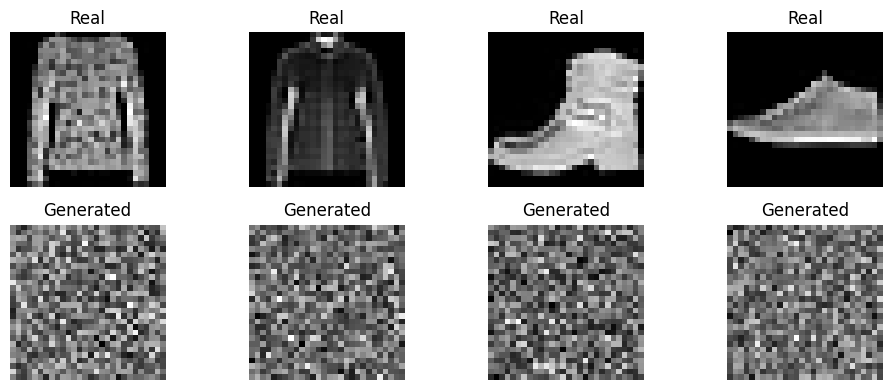

Epoch 16/20:  12%|█▏        | 15/125 [00:00<00:03, 32.32it/s]

  Batch 10: D(real)=0.928, D(fake)=0.003


Epoch 16/20:  15%|█▌        | 19/125 [00:00<00:03, 30.05it/s]

  Batch 20: D(real)=0.897, D(fake)=0.003


Epoch 16/20:  25%|██▍       | 31/125 [00:01<00:06, 13.83it/s]

  Batch 30: D(real)=0.882, D(fake)=0.002


Epoch 16/20:  33%|███▎      | 41/125 [00:02<00:07, 11.27it/s]

  Batch 40: D(real)=0.890, D(fake)=0.003


Epoch 16/20:  41%|████      | 51/125 [00:03<00:09,  7.77it/s]

  Batch 50: D(real)=0.889, D(fake)=0.003


Epoch 16/20:  49%|████▉     | 61/125 [00:05<00:08,  7.96it/s]

  Batch 60: D(real)=0.855, D(fake)=0.003


Epoch 16/20:  58%|█████▊    | 72/125 [00:06<00:05,  9.19it/s]

  Batch 70: D(real)=0.877, D(fake)=0.003


Epoch 16/20:  65%|██████▍   | 81/125 [00:08<00:05,  8.02it/s]

  Batch 80: D(real)=0.919, D(fake)=0.003


Epoch 16/20:  73%|███████▎  | 91/125 [00:09<00:03,  8.67it/s]

  Batch 90: D(real)=0.896, D(fake)=0.003


Epoch 16/20:  81%|████████  | 101/125 [00:10<00:02,  8.46it/s]

  Batch 100: D(real)=0.867, D(fake)=0.003


Epoch 16/20:  89%|████████▉ | 111/125 [00:11<00:01,  7.32it/s]

  Batch 110: D(real)=0.861, D(fake)=0.002


Epoch 16/20:  97%|█████████▋| 121/125 [00:13<00:00,  7.87it/s]

  Batch 120: D(real)=0.881, D(fake)=0.003


Epoch 16/20: 100%|██████████| 125/125 [00:14<00:00,  8.78it/s]


Epoch 16/20 - D Loss: 0.3468, G Loss: 5.4185


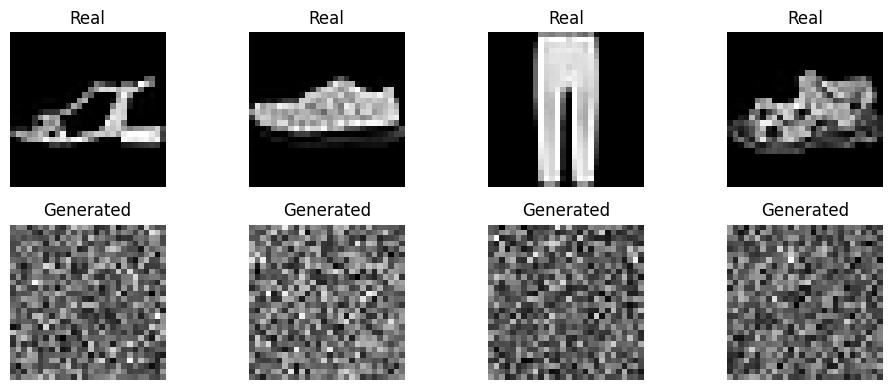

Epoch 17/20:   9%|▉         | 11/125 [00:01<00:18,  6.19it/s]

  Batch 10: D(real)=0.912, D(fake)=0.004


Epoch 17/20:  16%|█▌        | 20/125 [00:02<00:13,  8.05it/s]

  Batch 20: D(real)=0.906, D(fake)=0.003


Epoch 17/20:  25%|██▍       | 31/125 [00:04<00:15,  6.11it/s]

  Batch 30: D(real)=0.895, D(fake)=0.003


Epoch 17/20:  33%|███▎      | 41/125 [00:05<00:10,  8.26it/s]

  Batch 40: D(real)=0.886, D(fake)=0.003


Epoch 17/20:  41%|████      | 51/125 [00:07<00:09,  7.73it/s]

  Batch 50: D(real)=0.847, D(fake)=0.002


Epoch 17/20:  49%|████▉     | 61/125 [00:09<00:09,  6.41it/s]

  Batch 60: D(real)=0.890, D(fake)=0.003


Epoch 17/20:  57%|█████▋    | 71/125 [00:10<00:06,  8.74it/s]

  Batch 70: D(real)=0.878, D(fake)=0.002


Epoch 17/20:  65%|██████▍   | 81/125 [00:11<00:04,  8.99it/s]

  Batch 80: D(real)=0.899, D(fake)=0.002


Epoch 17/20:  74%|███████▎  | 92/125 [00:12<00:03, 10.57it/s]

  Batch 90: D(real)=0.908, D(fake)=0.003


Epoch 17/20:  81%|████████  | 101/125 [00:14<00:02,  9.68it/s]

  Batch 100: D(real)=0.870, D(fake)=0.003


Epoch 17/20:  89%|████████▉ | 111/125 [00:14<00:01, 11.62it/s]

  Batch 110: D(real)=0.882, D(fake)=0.002


Epoch 17/20:  97%|█████████▋| 121/125 [00:15<00:00,  9.68it/s]

  Batch 120: D(real)=0.883, D(fake)=0.002


Epoch 17/20: 100%|██████████| 125/125 [00:16<00:00,  7.64it/s]


Epoch 17/20 - D Loss: 0.3458, G Loss: 5.4546


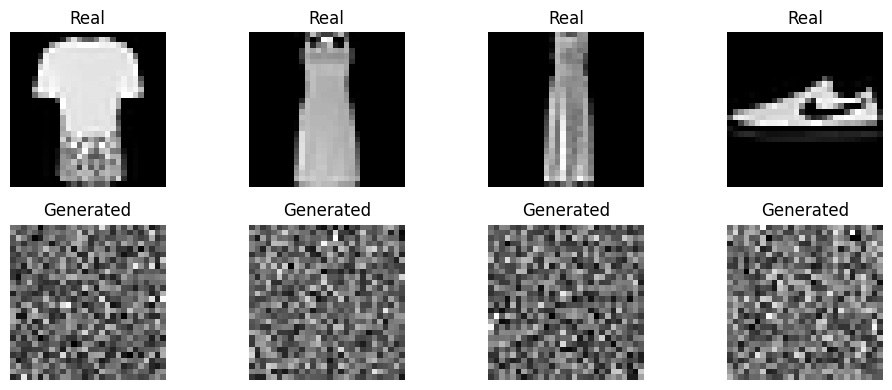

Epoch 18/20:   9%|▉         | 11/125 [00:00<00:09, 12.20it/s]

  Batch 10: D(real)=0.881, D(fake)=0.003


Epoch 18/20:  17%|█▋        | 21/125 [00:01<00:09, 10.74it/s]

  Batch 20: D(real)=0.904, D(fake)=0.002


Epoch 18/20:  25%|██▍       | 31/125 [00:02<00:07, 12.29it/s]

  Batch 30: D(real)=0.887, D(fake)=0.002


Epoch 18/20:  33%|███▎      | 41/125 [00:03<00:07, 10.64it/s]

  Batch 40: D(real)=0.870, D(fake)=0.002


Epoch 18/20:  42%|████▏     | 52/125 [00:04<00:06, 10.83it/s]

  Batch 50: D(real)=0.867, D(fake)=0.002


Epoch 18/20:  50%|████▉     | 62/125 [00:05<00:05, 12.32it/s]

  Batch 60: D(real)=0.879, D(fake)=0.002


Epoch 18/20:  58%|█████▊    | 72/125 [00:06<00:04, 11.77it/s]

  Batch 70: D(real)=0.866, D(fake)=0.002


Epoch 18/20:  65%|██████▍   | 81/125 [00:07<00:04,  9.27it/s]

  Batch 80: D(real)=0.890, D(fake)=0.003


Epoch 18/20:  74%|███████▎  | 92/125 [00:08<00:03,  9.51it/s]

  Batch 90: D(real)=0.891, D(fake)=0.002


Epoch 18/20:  81%|████████  | 101/125 [00:10<00:04,  5.88it/s]

  Batch 100: D(real)=0.886, D(fake)=0.002


Epoch 18/20:  88%|████████▊ | 110/125 [00:12<00:04,  3.71it/s]

  Batch 110: D(real)=0.860, D(fake)=0.002


Epoch 18/20:  97%|█████████▋| 121/125 [00:15<00:00,  5.40it/s]

  Batch 120: D(real)=0.864, D(fake)=0.002


Epoch 18/20: 100%|██████████| 125/125 [00:16<00:00,  7.46it/s]


Epoch 18/20 - D Loss: 0.3447, G Loss: 5.6589


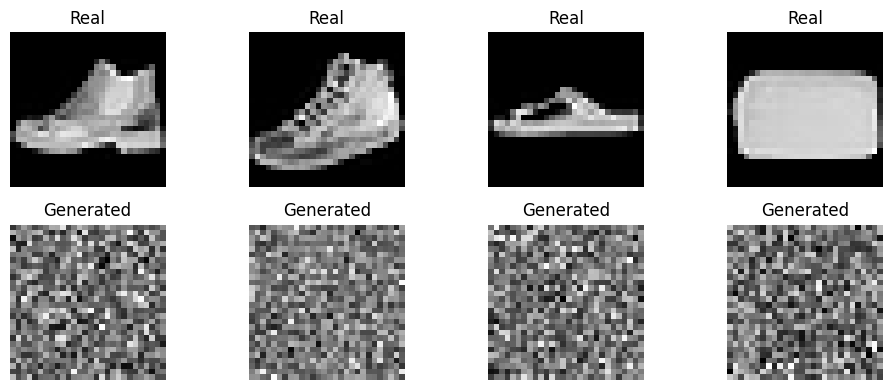

Epoch 19/20:   8%|▊         | 10/125 [00:01<00:19,  5.89it/s]

  Batch 10: D(real)=0.879, D(fake)=0.002


Epoch 19/20:  18%|█▊        | 22/125 [00:03<00:14,  7.02it/s]

  Batch 20: D(real)=0.906, D(fake)=0.005


Epoch 19/20:  27%|██▋       | 34/125 [00:04<00:06, 14.76it/s]

  Batch 30: D(real)=0.876, D(fake)=0.003


Epoch 19/20:  34%|███▍      | 43/125 [00:05<00:04, 20.07it/s]

  Batch 40: D(real)=0.902, D(fake)=0.002


Epoch 19/20:  42%|████▏     | 52/125 [00:05<00:03, 22.36it/s]

  Batch 50: D(real)=0.895, D(fake)=0.003


Epoch 19/20:  51%|█████     | 64/125 [00:06<00:02, 22.56it/s]

  Batch 60: D(real)=0.878, D(fake)=0.002


Epoch 19/20:  58%|█████▊    | 73/125 [00:06<00:03, 13.97it/s]

  Batch 70: D(real)=0.884, D(fake)=0.002


Epoch 19/20:  65%|██████▍   | 81/125 [00:07<00:04, 10.65it/s]

  Batch 80: D(real)=0.900, D(fake)=0.002


Epoch 19/20:  74%|███████▎  | 92/125 [00:09<00:03,  9.27it/s]

  Batch 90: D(real)=0.892, D(fake)=0.002


Epoch 19/20:  82%|████████▏ | 102/125 [00:10<00:02, 11.41it/s]

  Batch 100: D(real)=0.882, D(fake)=0.002


Epoch 19/20:  89%|████████▉ | 111/125 [00:11<00:01,  9.48it/s]

  Batch 110: D(real)=0.826, D(fake)=0.002


Epoch 19/20:  97%|█████████▋| 121/125 [00:13<00:00,  6.48it/s]

  Batch 120: D(real)=0.899, D(fake)=0.003


Epoch 19/20: 100%|██████████| 125/125 [00:13<00:00,  9.17it/s]


Epoch 19/20 - D Loss: 0.3441, G Loss: 5.5227


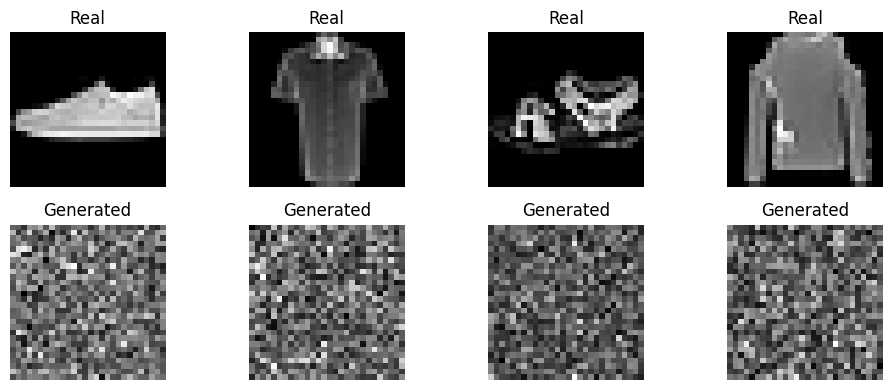

Epoch 20/20:  10%|▉         | 12/125 [00:00<00:08, 13.40it/s]

  Batch 10: D(real)=0.873, D(fake)=0.002


Epoch 20/20:  18%|█▊        | 23/125 [00:01<00:06, 15.22it/s]

  Batch 20: D(real)=0.909, D(fake)=0.002


Epoch 20/20:  26%|██▌       | 32/125 [00:02<00:04, 20.08it/s]

  Batch 30: D(real)=0.928, D(fake)=0.003


Epoch 20/20:  34%|███▎      | 42/125 [00:02<00:05, 16.57it/s]

  Batch 40: D(real)=0.881, D(fake)=0.002


Epoch 20/20:  42%|████▏     | 52/125 [00:03<00:04, 16.07it/s]


  Batch 50: D(real)=0.870, D(fake)=0.002


KeyboardInterrupt: 

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

# Drastically simplified configuration
HIDDEN_SIZE = 32  # Even smaller hidden size
N_HIDDEN_LAYERS = 1  # Just one hidden layer in SIREN
OMEGA_0 = 30.0
IMAGE_CHANNELS = 1
Z_DIM = 32  # Smaller latent dimension

# Data Loading with tiny subset and larger batch
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transform)

# Create a very small subset for faster experimentation
subset_size = 2000  # Use only 2000 samples initially
indices = torch.randperm(len(train_set))[:subset_size]
subset = torch.utils.data.Subset(train_set, indices)

batch_size = 16  # Larger batch for more stable gradients
train_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True)

def positional_encoding(coords, num_bands=2):  # Minimal encoding
    pos_enc = [coords]
    for i in range(num_bands):
        freq = 2.0 ** i
        pos_enc.append(torch.sin(coords * freq * np.pi))
        pos_enc.append(torch.cos(coords * freq * np.pi))
    return torch.cat(pos_enc, dim=-1)

def get_mgrid(sidelen, dim=2, num_bands=2):
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)
    coords = [torch.linspace(-1, 1, s) for s in sidelen]
    mesh_coords = torch.meshgrid(*coords, indexing='ij')  
    coords = torch.stack(mesh_coords, dim=-1).reshape(-1, dim)
    return positional_encoding(coords, num_bands)

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0=OMEGA_0):
        super().__init__()
        self.omega_0 = omega_0
        self.in_features = in_features
        self.out_features = out_features
    
    def forward(self, input, weights):
        weight_size = self.out_features * self.in_features
        W = weights[:weight_size].view(self.out_features, self.in_features)
        b = weights[weight_size:weight_size + self.out_features]
        return torch.sin(self.omega_0 * F.linear(input, W, b))

class SimpleSIREN(nn.Module):
    def __init__(self, in_features=2+2*2*2, hidden_size=HIDDEN_SIZE, 
                 n_hidden_layers=N_HIDDEN_LAYERS, output_features=IMAGE_CHANNELS):
        super().__init__()
        self.in_features = in_features
        self.hidden_size = hidden_size
        self.output_features = output_features
        
        # Create sine layers (without weights)
        self.layers = nn.ModuleList()
        self.layers.append(SineLayer(in_features, hidden_size))
        
        for _ in range(n_hidden_layers):
            self.layers.append(SineLayer(hidden_size, hidden_size))
        
        # Calculate total parameter count
        self.total_params = (in_features * hidden_size + hidden_size)  # First layer
        self.total_params += n_hidden_layers * (hidden_size * hidden_size + hidden_size)  # Hidden layers
        self.total_params += (hidden_size * output_features + output_features)  # Final layer
    
    def forward(self, x, all_weights):
        """Forward pass using dynamically generated weights"""
        start_idx = 0
        
        # First layer
        first_layer_size = self.hidden_size * self.in_features + self.hidden_size
        x = self.layers[0](x, all_weights[start_idx:start_idx + first_layer_size])
        start_idx += first_layer_size
        
        # Hidden layers
        for layer in self.layers[1:]:
            layer_size = self.hidden_size * self.hidden_size + self.hidden_size
            x = layer(x, all_weights[start_idx:start_idx + layer_size])
            start_idx += layer_size
        
        # Final layer (manually apply linear + sigmoid)
        final_weight_size = self.output_features * self.hidden_size
        W_final = all_weights[start_idx:start_idx + final_weight_size].view(
            self.output_features, self.hidden_size)
        b_final = all_weights[start_idx + final_weight_size:
                             start_idx + final_weight_size + self.output_features]
        
        x = F.linear(x, W_final, b_final)
        x = torch.sigmoid(x)
        
        return x

class SimpleGenerator(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        
        # Create SIREN template to get parameter count
        self.siren = SimpleSIREN()
        total_siren_weights = self.siren.total_params
        
        # Very simple generator - just enough to generate weights
        self.gen_net = nn.Sequential(
            nn.Linear(z_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, total_siren_weights),
            nn.Tanh()  # Keep weights in a reasonable range
        )
        
    def forward(self, z, grid):
        # Generate weights for SIREN
        batch_size = z.size(0)
        siren_weights = self.gen_net(z)
        
        # Create images by running SIREN with these weights
        images = []
        for i in range(batch_size):
            # Run SIREN on coordinate grid with generated weights
            pixel_values = self.siren(grid, siren_weights[i])
            
            # Reshape to image dimensions
            image = pixel_values.reshape(28, 28).unsqueeze(0)
            images.append(image)
        
        # Stack all images into a batch
        images = torch.stack(images)
        
        return images, siren_weights

class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Very minimal discriminator - must be weak for GAN stability
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

class SimpleGAN(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        
        self.generator = SimpleGenerator(z_dim=z_dim)
        self.discriminator = SimpleDiscriminator()
        self.z_dim = z_dim
    
    def forward(self, z, grid):
        images, _ = self.generator(z, grid)
        return images

# Optimized training function
def train_simple_gan(gan, train_loader, grid, num_epochs=10, device="cpu"):
    # Optimizers with lower learning rate for G
    optimizer_g = optim.Adam(gan.generator.parameters(), lr=0.00005, betas=(0.5, 0.999))  # Very low learning rate
    optimizer_d = optim.Adam(gan.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Training stats
    d_losses = []
    g_losses = []
    
    gan.train()
    
    for epoch in range(num_epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0
        batch_count = 0
        
        for real_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            batch_count += 1
            
            # Labels - only smooth the real labels
            real_labels = torch.ones(batch_size, 1).to(device) * 0.9  # One-sided label smoothing
            fake_labels = torch.zeros(batch_size, 1).to(device)
            
            # ---------------------
            # Train Discriminator
            # ---------------------
            if batch_count % 3 == 0:  # Train D less frequently than G
                optimizer_d.zero_grad()
                
                # Real images
                d_real = gan.discriminator(real_images)
                d_real_loss = criterion(d_real, real_labels)
                
                # Fake images
                z = torch.randn(batch_size, gan.z_dim).to(device) * 0.5
                fake_images, _ = gan.generator(z, grid)
                d_fake = gan.discriminator(fake_images.detach())
                d_fake_loss = criterion(d_fake, fake_labels)
                
                # Combined loss and backprop
                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(gan.discriminator.parameters(), 1.0)
                optimizer_d.step()
            else:
                # Just compute the loss for tracking, but don't update D
                with torch.no_grad():
                    d_real = gan.discriminator(real_images)
                    d_real_loss = criterion(d_real, real_labels)
                    
                    z = torch.randn(batch_size, gan.z_dim).to(device) * 0.5
                    fake_images, _ = gan.generator(z, grid)
                    d_fake = gan.discriminator(fake_images.detach())
                    d_fake_loss = criterion(d_fake, fake_labels)
                    
                    d_loss = d_real_loss + d_fake_loss
            
            # ---------------------
            # Train Generator
            # ---------------------
            optimizer_g.zero_grad()
            
            # Generate images
            z = torch.randn(batch_size, gan.z_dim).to(device) * 0.5
            fake_images, _ = gan.generator(z, grid)
            
            # Standard generator loss - fool the discriminator
            d_fake = gan.discriminator(fake_images)
            g_loss = criterion(d_fake, real_labels)
            
            # Backprop
            g_loss.backward()
            torch.nn.utils.clip_grad_norm_(gan.generator.parameters(), 1.0)
            optimizer_g.step()
            
            # Record losses
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            
            # Monitor progress
            if batch_count % 10 == 0:
                d_real_mean = d_real.mean().item()
                d_fake_mean = d_fake.mean().item()
                print(f"  Batch {batch_count}: D(real)={d_real_mean:.3f}, D(fake)={d_fake_mean:.3f}")
                
        # Calculate average losses for this epoch
        epoch_d_loss /= batch_count
        epoch_g_loss /= batch_count
        
        # Save losses for plotting
        d_losses.append(epoch_d_loss)
        g_losses.append(epoch_g_loss)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - D Loss: {epoch_d_loss:.4f}, G Loss: {epoch_g_loss:.4f}")
        
        # Visualize sample images every epoch
        visualize_samples(gan, real_images, fake_images, device)
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Losses')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return gan, d_losses, g_losses

def visualize_samples(gan, real_images, fake_images, device, num_examples=4):
    """Visualize real and generated samples"""
    plt.figure(figsize=(10, 4))
    
    # Show real images
    for i in range(min(num_examples, len(real_images))):
        plt.subplot(2, num_examples, i+1)
        plt.imshow(real_images[i].detach().cpu().squeeze(0), cmap="gray")
        plt.title("Real")
        plt.axis("off")
    
    # Show fake images
    for i in range(min(num_examples, len(fake_images))):
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(fake_images[i].detach().cpu().squeeze(0), cmap="gray")
        plt.title("Generated")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create coordinate grid (minimal positional encoding)
    grid = get_mgrid(28, dim=2, num_bands=2).to(device)
    
    # Create simplified GAN
    gan = SimpleGAN(z_dim=Z_DIM).to(device)
    
    # Train with heavily optimized settings
    gan, d_losses, g_losses = train_simple_gan(gan, train_loader, grid, num_epochs=20, device=device)
    
    # Generate final samples
    gan.eval()
    with torch.no_grad():
        z = torch.randn(8, Z_DIM).to(device) * 0.5  # Reduced noise magnitude
        generated_images, _ = gan.generator(z, grid)
        
        plt.figure(figsize=(12, 3))
        for i in range(8):
            plt.subplot(1, 8, i+1)
            plt.imshow(generated_images[i].cpu().squeeze(0), cmap="gray")
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()

Using device: cpu


Epoch 1/20:   6%|▋         | 8/125 [00:00<00:01, 75.04it/s]

  Batch 10: D(real)=0.479, D(fake)=0.450


Epoch 1/20:  22%|██▏       | 27/125 [00:00<00:01, 84.71it/s]

  Batch 20: D(real)=0.482, D(fake)=0.427
  Batch 30: D(real)=0.483, D(fake)=0.396


Epoch 1/20:  35%|███▌      | 44/125 [00:00<00:01, 52.16it/s]

  Batch 40: D(real)=0.493, D(fake)=0.377


Epoch 1/20:  44%|████▍     | 55/125 [00:01<00:01, 40.26it/s]

  Batch 50: D(real)=0.488, D(fake)=0.348


Epoch 1/20:  51%|█████     | 64/125 [00:01<00:01, 34.80it/s]

  Batch 60: D(real)=0.488, D(fake)=0.309


Epoch 1/20:  57%|█████▋    | 71/125 [00:01<00:02, 21.18it/s]

  Batch 70: D(real)=0.517, D(fake)=0.300


Epoch 1/20:  66%|██████▋   | 83/125 [00:02<00:02, 15.17it/s]

  Batch 80: D(real)=0.544, D(fake)=0.272


Epoch 1/20:  73%|███████▎  | 91/125 [00:03<00:02, 12.81it/s]

  Batch 90: D(real)=0.541, D(fake)=0.243


Epoch 1/20:  81%|████████  | 101/125 [00:04<00:01, 12.24it/s]

  Batch 100: D(real)=0.553, D(fake)=0.234


Epoch 1/20:  90%|█████████ | 113/125 [00:05<00:00, 13.11it/s]

  Batch 110: D(real)=0.591, D(fake)=0.225


Epoch 1/20:  98%|█████████▊| 123/125 [00:06<00:00, 15.38it/s]

  Batch 120: D(real)=0.578, D(fake)=0.197


Epoch 1/20: 100%|██████████| 125/125 [00:06<00:00, 19.87it/s]


Epoch 1/20 - D Loss: 1.0538, G Loss: 1.1759


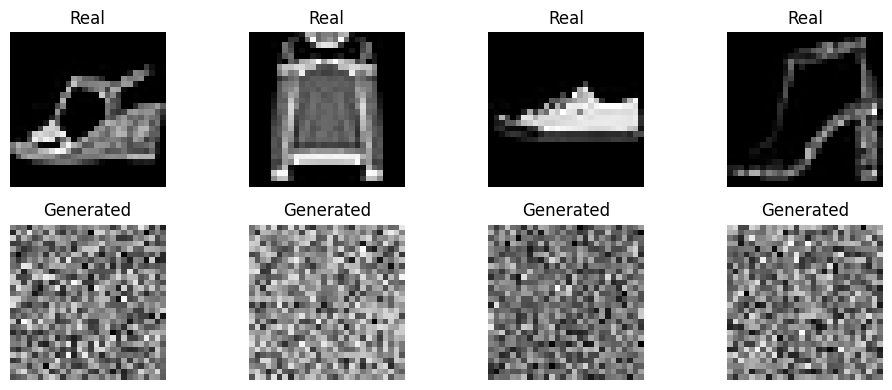

Epoch 2/20:  11%|█         | 14/125 [00:00<00:04, 26.77it/s]

  Batch 10: D(real)=0.597, D(fake)=0.175


Epoch 2/20:  17%|█▋        | 21/125 [00:00<00:03, 26.12it/s]

  Batch 20: D(real)=0.661, D(fake)=0.158


Epoch 2/20:  26%|██▋       | 33/125 [00:01<00:03, 25.57it/s]

  Batch 30: D(real)=0.633, D(fake)=0.160


Epoch 2/20:  36%|███▌      | 45/125 [00:01<00:03, 25.72it/s]

  Batch 40: D(real)=0.649, D(fake)=0.138


Epoch 2/20:  43%|████▎     | 54/125 [00:02<00:02, 25.85it/s]

  Batch 50: D(real)=0.710, D(fake)=0.128


Epoch 2/20:  50%|█████     | 63/125 [00:02<00:02, 24.11it/s]

  Batch 60: D(real)=0.748, D(fake)=0.109


Epoch 2/20:  58%|█████▊    | 72/125 [00:03<00:02, 21.59it/s]

  Batch 70: D(real)=0.730, D(fake)=0.113


Epoch 2/20:  68%|██████▊   | 85/125 [00:03<00:01, 24.55it/s]

  Batch 80: D(real)=0.753, D(fake)=0.084


Epoch 2/20:  76%|███████▌  | 95/125 [00:03<00:01, 25.61it/s]

  Batch 90: D(real)=0.683, D(fake)=0.078


Epoch 2/20:  83%|████████▎ | 104/125 [00:04<00:00, 25.62it/s]

  Batch 100: D(real)=0.768, D(fake)=0.074


Epoch 2/20:  90%|█████████ | 113/125 [00:04<00:00, 27.16it/s]

  Batch 110: D(real)=0.822, D(fake)=0.072


Epoch 2/20:  98%|█████████▊| 123/125 [00:05<00:00, 26.84it/s]

  Batch 120: D(real)=0.811, D(fake)=0.072


Epoch 2/20: 100%|██████████| 125/125 [00:05<00:00, 24.27it/s]


Epoch 2/20 - D Loss: 0.4674, G Loss: 2.2382


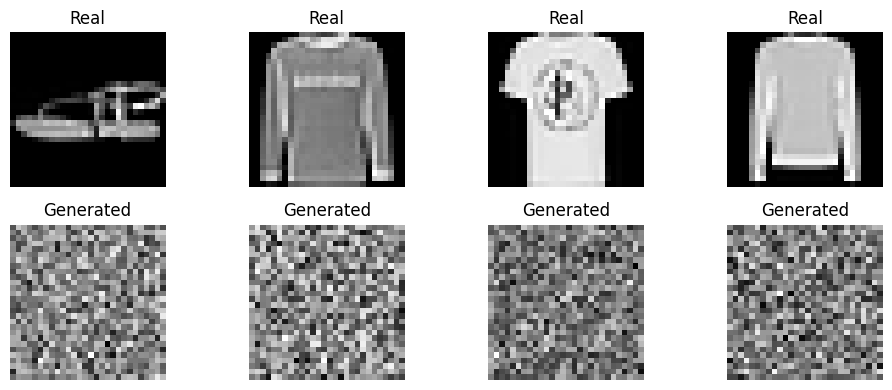

Epoch 3/20:  12%|█▏        | 15/125 [00:00<00:03, 28.38it/s]

  Batch 10: D(real)=0.844, D(fake)=0.056


Epoch 3/20:  17%|█▋        | 21/125 [00:00<00:05, 17.83it/s]

  Batch 20: D(real)=0.839, D(fake)=0.059


Epoch 3/20:  25%|██▍       | 31/125 [00:01<00:06, 15.57it/s]

  Batch 30: D(real)=0.820, D(fake)=0.047


Epoch 3/20:  35%|███▌      | 44/125 [00:02<00:03, 20.85it/s]

  Batch 40: D(real)=0.848, D(fake)=0.041


Epoch 3/20:  42%|████▏     | 53/125 [00:02<00:03, 19.06it/s]

  Batch 50: D(real)=0.865, D(fake)=0.041


Epoch 3/20:  52%|█████▏    | 65/125 [00:03<00:02, 22.81it/s]

  Batch 60: D(real)=0.879, D(fake)=0.041


Epoch 3/20:  59%|█████▉    | 74/125 [00:03<00:02, 23.47it/s]

  Batch 70: D(real)=0.928, D(fake)=0.033


Epoch 3/20:  66%|██████▋   | 83/125 [00:04<00:01, 24.49it/s]

  Batch 80: D(real)=0.920, D(fake)=0.028


Epoch 3/20:  76%|███████▌  | 95/125 [00:04<00:01, 26.23it/s]

  Batch 90: D(real)=0.905, D(fake)=0.028


Epoch 3/20:  84%|████████▍ | 105/125 [00:04<00:00, 27.40it/s]

  Batch 100: D(real)=0.915, D(fake)=0.028


Epoch 3/20:  91%|█████████ | 114/125 [00:05<00:00, 23.97it/s]

  Batch 110: D(real)=0.883, D(fake)=0.025


Epoch 3/20:  98%|█████████▊| 123/125 [00:05<00:00, 21.52it/s]

  Batch 120: D(real)=0.911, D(fake)=0.023


Epoch 3/20: 100%|██████████| 125/125 [00:05<00:00, 21.57it/s]


Epoch 3/20 - D Loss: 0.1772, G Loss: 3.3296


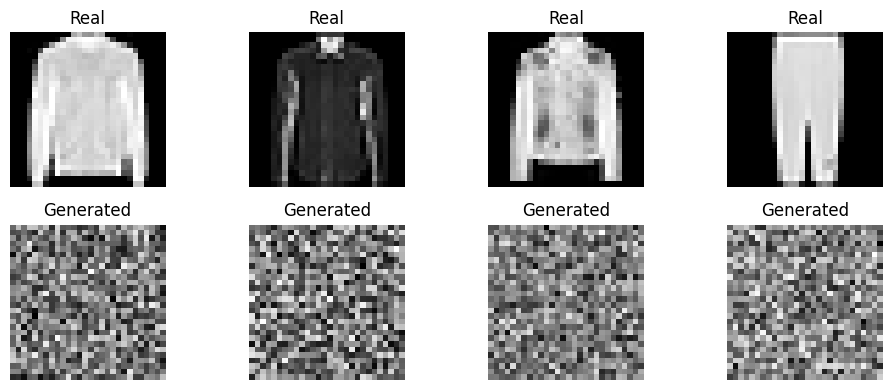

Epoch 4/20:   8%|▊         | 10/125 [00:00<00:04, 27.46it/s]

  Batch 10: D(real)=0.904, D(fake)=0.022


Epoch 4/20:  20%|██        | 25/125 [00:01<00:04, 24.23it/s]

  Batch 20: D(real)=0.914, D(fake)=0.022


Epoch 4/20:  27%|██▋       | 34/125 [00:01<00:03, 24.24it/s]

  Batch 30: D(real)=0.907, D(fake)=0.022


Epoch 4/20:  34%|███▍      | 43/125 [00:01<00:03, 21.63it/s]

  Batch 40: D(real)=0.943, D(fake)=0.026


Epoch 4/20:  44%|████▍     | 55/125 [00:02<00:03, 21.68it/s]

  Batch 50: D(real)=0.958, D(fake)=0.018


Epoch 4/20:  50%|████▉     | 62/125 [00:03<00:04, 12.81it/s]

  Batch 60: D(real)=0.894, D(fake)=0.017


Epoch 4/20:  58%|█████▊    | 72/125 [00:03<00:03, 15.19it/s]

  Batch 70: D(real)=0.973, D(fake)=0.016


Epoch 4/20:  66%|██████▌   | 82/125 [00:04<00:02, 19.28it/s]

  Batch 80: D(real)=0.926, D(fake)=0.016


Epoch 4/20:  75%|███████▌  | 94/125 [00:05<00:01, 21.31it/s]

  Batch 90: D(real)=0.946, D(fake)=0.021


Epoch 4/20:  82%|████████▏ | 103/125 [00:05<00:01, 15.16it/s]

  Batch 100: D(real)=0.928, D(fake)=0.016


Epoch 4/20:  89%|████████▉ | 111/125 [00:06<00:01, 12.46it/s]

  Batch 110: D(real)=0.954, D(fake)=0.013


Epoch 4/20:  98%|█████████▊| 123/125 [00:07<00:00, 16.32it/s]

  Batch 120: D(real)=0.947, D(fake)=0.016


Epoch 4/20: 100%|██████████| 125/125 [00:07<00:00, 16.98it/s]


Epoch 4/20 - D Loss: 0.0896, G Loss: 4.0492


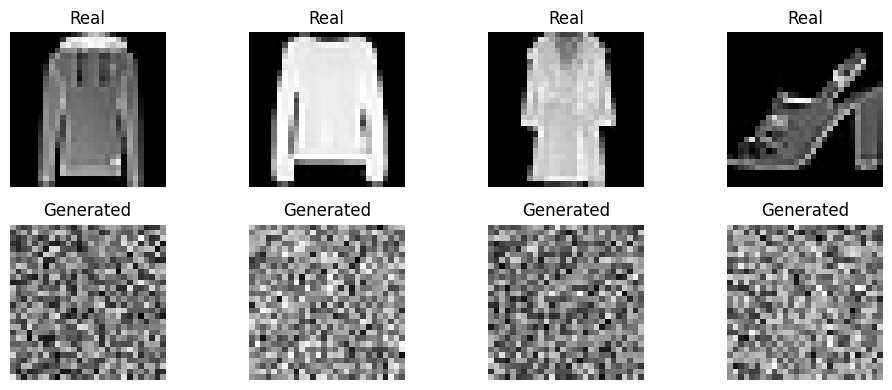

Epoch 5/20:  10%|▉         | 12/125 [00:00<00:06, 17.48it/s]

  Batch 10: D(real)=0.963, D(fake)=0.013


Epoch 5/20:  18%|█▊        | 23/125 [00:01<00:04, 21.41it/s]

  Batch 20: D(real)=0.974, D(fake)=0.013


Epoch 5/20:  28%|██▊       | 35/125 [00:01<00:03, 23.54it/s]

  Batch 30: D(real)=0.931, D(fake)=0.010


Epoch 5/20:  36%|███▌      | 45/125 [00:02<00:03, 26.61it/s]

  Batch 40: D(real)=0.936, D(fake)=0.009


Epoch 5/20:  44%|████▍     | 55/125 [00:02<00:02, 28.29it/s]

  Batch 50: D(real)=0.979, D(fake)=0.010


Epoch 5/20:  52%|█████▏    | 65/125 [00:02<00:02, 29.15it/s]

  Batch 60: D(real)=0.951, D(fake)=0.009


Epoch 5/20:  58%|█████▊    | 73/125 [00:03<00:01, 29.96it/s]

  Batch 70: D(real)=0.977, D(fake)=0.011


Epoch 5/20:  68%|██████▊   | 85/125 [00:03<00:01, 24.22it/s]

  Batch 80: D(real)=0.940, D(fake)=0.015


Epoch 5/20:  75%|███████▌  | 94/125 [00:03<00:01, 26.71it/s]

  Batch 90: D(real)=0.953, D(fake)=0.013


Epoch 5/20:  83%|████████▎ | 104/125 [00:04<00:00, 28.84it/s]

  Batch 100: D(real)=0.961, D(fake)=0.010


Epoch 5/20:  92%|█████████▏| 115/125 [00:04<00:00, 29.10it/s]

  Batch 110: D(real)=0.978, D(fake)=0.012


Epoch 5/20: 100%|██████████| 125/125 [00:04<00:00, 25.55it/s]


  Batch 120: D(real)=0.965, D(fake)=0.011
Epoch 5/20 - D Loss: 0.0551, G Loss: 4.5712


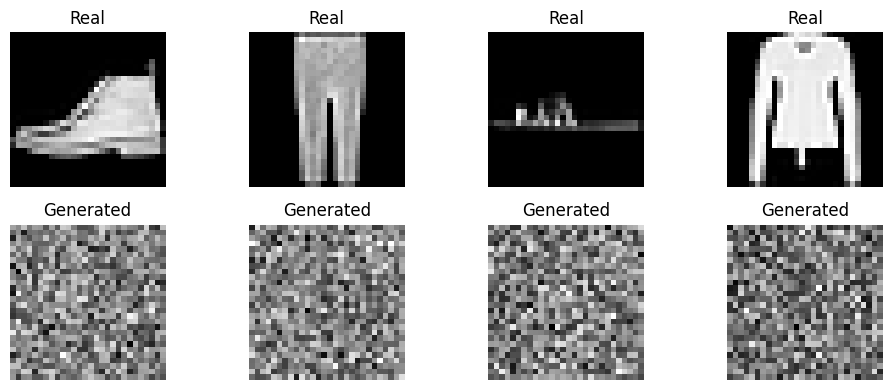

Epoch 6/20:  13%|█▎        | 16/125 [00:00<00:03, 32.22it/s]

  Batch 10: D(real)=0.955, D(fake)=0.008


Epoch 6/20:  19%|█▉        | 24/125 [00:00<00:03, 31.00it/s]

  Batch 20: D(real)=0.978, D(fake)=0.009


Epoch 6/20:  29%|██▉       | 36/125 [00:01<00:02, 31.42it/s]

  Batch 30: D(real)=0.972, D(fake)=0.008


Epoch 6/20:  32%|███▏      | 40/125 [00:01<00:02, 31.38it/s]

  Batch 40: D(real)=0.978, D(fake)=0.007


Epoch 6/20:  42%|████▏     | 53/125 [00:01<00:02, 26.34it/s]

  Batch 50: D(real)=0.976, D(fake)=0.008


Epoch 6/20:  51%|█████     | 64/125 [00:02<00:02, 28.66it/s]

  Batch 60: D(real)=0.983, D(fake)=0.006


Epoch 6/20:  59%|█████▉    | 74/125 [00:02<00:01, 29.64it/s]

  Batch 70: D(real)=0.985, D(fake)=0.005


Epoch 6/20:  68%|██████▊   | 85/125 [00:02<00:01, 30.88it/s]

  Batch 80: D(real)=0.987, D(fake)=0.005


Epoch 6/20:  74%|███████▍  | 93/125 [00:03<00:01, 31.38it/s]

  Batch 90: D(real)=0.985, D(fake)=0.008


Epoch 6/20:  84%|████████▍ | 105/125 [00:03<00:00, 30.89it/s]

  Batch 100: D(real)=0.985, D(fake)=0.010


Epoch 6/20:  90%|█████████ | 113/125 [00:03<00:00, 31.89it/s]

  Batch 110: D(real)=0.979, D(fake)=0.007


Epoch 6/20: 100%|██████████| 125/125 [00:04<00:00, 30.13it/s]

  Batch 120: D(real)=0.985, D(fake)=0.006
Epoch 6/20 - D Loss: 0.0382, G Loss: 5.0213


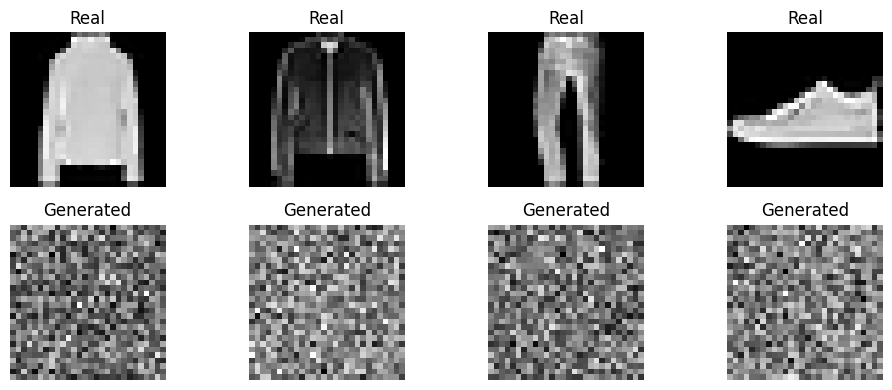

Epoch 7/20:  14%|█▎        | 17/125 [00:00<00:03, 31.30it/s]

  Batch 10: D(real)=0.982, D(fake)=0.005


Epoch 7/20:  20%|██        | 25/125 [00:00<00:03, 32.29it/s]

  Batch 20: D(real)=0.991, D(fake)=0.005


Epoch 7/20:  26%|██▋       | 33/125 [00:01<00:02, 31.55it/s]

  Batch 30: D(real)=0.983, D(fake)=0.004


Epoch 7/20:  36%|███▌      | 45/125 [00:01<00:02, 32.86it/s]

  Batch 40: D(real)=0.973, D(fake)=0.005


Epoch 7/20:  42%|████▏     | 53/125 [00:01<00:02, 31.09it/s]

  Batch 50: D(real)=0.989, D(fake)=0.004


Epoch 7/20:  52%|█████▏    | 65/125 [00:02<00:01, 31.88it/s]

  Batch 60: D(real)=0.954, D(fake)=0.006


Epoch 7/20:  62%|██████▏   | 77/125 [00:02<00:01, 32.87it/s]

  Batch 70: D(real)=0.988, D(fake)=0.007


Epoch 7/20:  68%|██████▊   | 85/125 [00:02<00:01, 33.34it/s]

  Batch 80: D(real)=0.990, D(fake)=0.007


Epoch 7/20:  78%|███████▊  | 97/125 [00:03<00:00, 33.76it/s]

  Batch 90: D(real)=0.986, D(fake)=0.005


Epoch 7/20:  84%|████████▍ | 105/125 [00:03<00:00, 25.51it/s]

  Batch 100: D(real)=0.995, D(fake)=0.005


Epoch 7/20:  90%|█████████ | 113/125 [00:03<00:00, 28.19it/s]

  Batch 110: D(real)=0.976, D(fake)=0.003


Epoch 7/20: 100%|██████████| 125/125 [00:04<00:00, 30.31it/s]

  Batch 120: D(real)=0.993, D(fake)=0.003
Epoch 7/20 - D Loss: 0.0286, G Loss: 5.4280


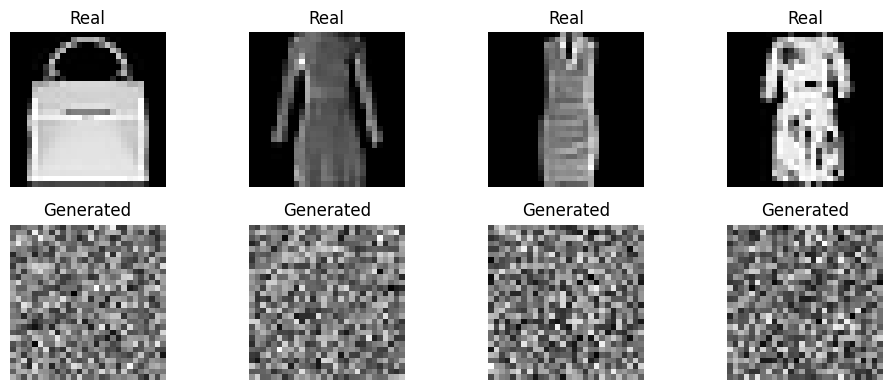

Epoch 8/20:  13%|█▎        | 16/125 [00:00<00:03, 33.20it/s]

  Batch 10: D(real)=0.987, D(fake)=0.004


Epoch 8/20:  19%|█▉        | 24/125 [00:00<00:03, 31.77it/s]

  Batch 20: D(real)=0.973, D(fake)=0.004


Epoch 8/20:  29%|██▉       | 36/125 [00:01<00:02, 31.96it/s]

  Batch 30: D(real)=0.972, D(fake)=0.004


Epoch 8/20:  35%|███▌      | 44/125 [00:01<00:02, 32.65it/s]

  Batch 40: D(real)=0.992, D(fake)=0.004


Epoch 8/20:  45%|████▍     | 56/125 [00:01<00:02, 32.79it/s]

  Batch 50: D(real)=0.996, D(fake)=0.004


Epoch 8/20:  51%|█████     | 64/125 [00:02<00:02, 26.07it/s]

  Batch 60: D(real)=0.990, D(fake)=0.007


Epoch 8/20:  61%|██████    | 76/125 [00:02<00:01, 29.16it/s]

  Batch 70: D(real)=0.998, D(fake)=0.006


Epoch 8/20:  67%|██████▋   | 84/125 [00:02<00:01, 30.16it/s]

  Batch 80: D(real)=0.989, D(fake)=0.007


Epoch 8/20:  77%|███████▋  | 96/125 [00:03<00:00, 29.69it/s]

  Batch 90: D(real)=0.998, D(fake)=0.005


Epoch 8/20:  83%|████████▎ | 104/125 [00:03<00:00, 30.09it/s]

  Batch 100: D(real)=0.984, D(fake)=0.004


Epoch 8/20:  90%|████████▉ | 112/125 [00:03<00:00, 29.70it/s]

  Batch 110: D(real)=0.992, D(fake)=0.003


Epoch 8/20: 100%|██████████| 125/125 [00:04<00:00, 30.20it/s]


  Batch 120: D(real)=0.987, D(fake)=0.003
Epoch 8/20 - D Loss: 0.0226, G Loss: 5.5379


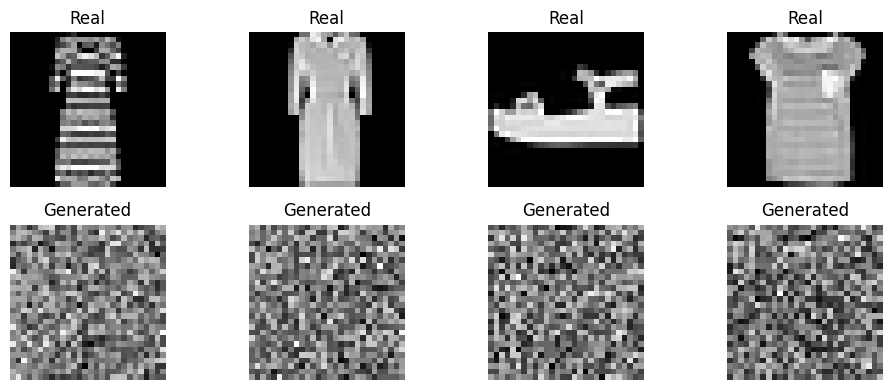

Epoch 9/20:  11%|█         | 14/125 [00:00<00:04, 24.21it/s]

  Batch 10: D(real)=0.986, D(fake)=0.003


Epoch 9/20:  18%|█▊        | 23/125 [00:01<00:04, 23.24it/s]

  Batch 20: D(real)=0.980, D(fake)=0.002


Epoch 9/20:  26%|██▌       | 32/125 [00:01<00:04, 22.41it/s]

  Batch 30: D(real)=0.994, D(fake)=0.002


Epoch 9/20:  35%|███▌      | 44/125 [00:01<00:03, 24.91it/s]

  Batch 40: D(real)=0.988, D(fake)=0.003


Epoch 9/20:  42%|████▏     | 53/125 [00:02<00:02, 26.09it/s]

  Batch 50: D(real)=0.998, D(fake)=0.003


Epoch 9/20:  52%|█████▏    | 65/125 [00:02<00:02, 27.53it/s]

  Batch 60: D(real)=0.991, D(fake)=0.003


Epoch 9/20:  59%|█████▉    | 74/125 [00:03<00:01, 26.26it/s]

  Batch 70: D(real)=0.994, D(fake)=0.003


Epoch 9/20:  66%|██████▋   | 83/125 [00:03<00:01, 24.27it/s]

  Batch 80: D(real)=0.977, D(fake)=0.003


Epoch 9/20:  74%|███████▎  | 92/125 [00:04<00:01, 18.37it/s]

  Batch 90: D(real)=0.985, D(fake)=0.004


Epoch 9/20:  83%|████████▎ | 104/125 [00:04<00:00, 24.66it/s]

  Batch 100: D(real)=0.992, D(fake)=0.005


Epoch 9/20:  90%|█████████ | 113/125 [00:04<00:00, 26.81it/s]

  Batch 110: D(real)=0.984, D(fake)=0.004


Epoch 9/20: 100%|██████████| 125/125 [00:05<00:00, 24.07it/s]


  Batch 120: D(real)=0.985, D(fake)=0.003
Epoch 9/20 - D Loss: 0.0183, G Loss: 5.8994


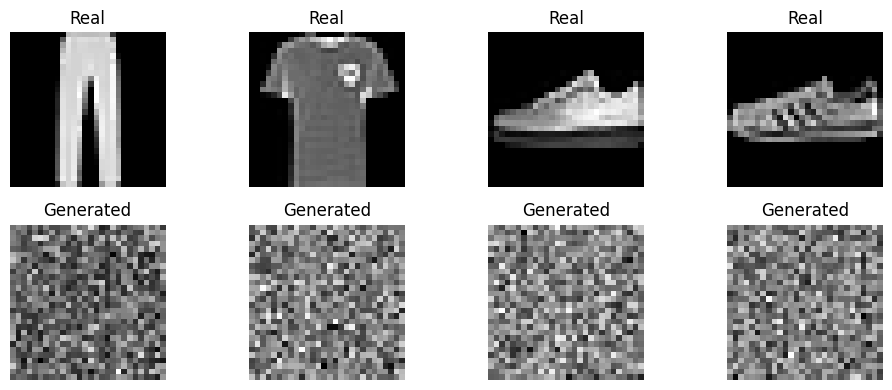

Epoch 10/20:  13%|█▎        | 16/125 [00:00<00:03, 32.94it/s]

  Batch 10: D(real)=0.990, D(fake)=0.003


Epoch 10/20:  19%|█▉        | 24/125 [00:00<00:03, 30.73it/s]

  Batch 20: D(real)=0.997, D(fake)=0.002


Epoch 10/20:  29%|██▉       | 36/125 [00:01<00:02, 31.02it/s]

  Batch 30: D(real)=0.984, D(fake)=0.003


Epoch 10/20:  34%|███▍      | 43/125 [00:01<00:03, 25.59it/s]

  Batch 40: D(real)=0.994, D(fake)=0.003


Epoch 10/20:  42%|████▏     | 53/125 [00:01<00:02, 28.70it/s]

  Batch 50: D(real)=0.965, D(fake)=0.003


Epoch 10/20:  52%|█████▏    | 65/125 [00:02<00:02, 29.69it/s]

  Batch 60: D(real)=0.988, D(fake)=0.002


Epoch 10/20:  58%|█████▊    | 73/125 [00:02<00:01, 30.65it/s]

  Batch 70: D(real)=0.996, D(fake)=0.003


Epoch 10/20:  66%|██████▋   | 83/125 [00:02<00:01, 24.73it/s]

  Batch 80: D(real)=0.992, D(fake)=0.003


Epoch 10/20:  76%|███████▌  | 95/125 [00:03<00:01, 23.54it/s]

  Batch 90: D(real)=0.996, D(fake)=0.002


Epoch 10/20:  83%|████████▎ | 104/125 [00:03<00:00, 23.53it/s]

  Batch 100: D(real)=0.988, D(fake)=0.002


Epoch 10/20:  90%|█████████ | 113/125 [00:04<00:00, 23.26it/s]

  Batch 110: D(real)=0.997, D(fake)=0.002


Epoch 10/20: 100%|██████████| 125/125 [00:04<00:00, 26.10it/s]


  Batch 120: D(real)=0.994, D(fake)=0.002
Epoch 10/20 - D Loss: 0.0157, G Loss: 6.1045


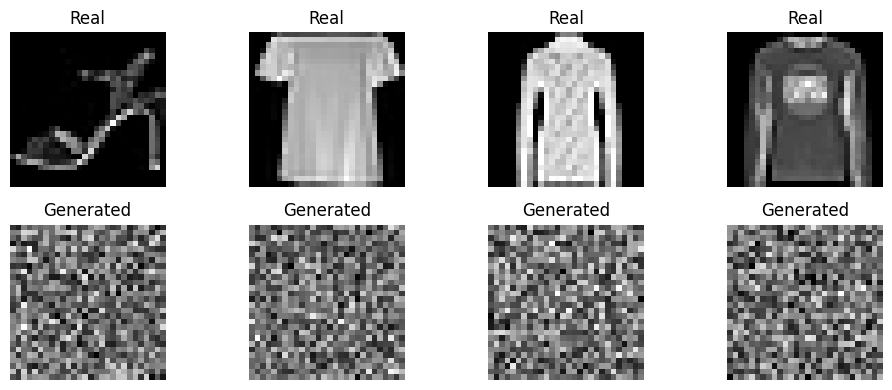

Epoch 11/20:  10%|█         | 13/125 [00:00<00:03, 29.19it/s]

  Batch 10: D(real)=0.947, D(fake)=0.002


Epoch 11/20:  20%|██        | 25/125 [00:00<00:03, 27.09it/s]

  Batch 20: D(real)=0.990, D(fake)=0.002


Epoch 11/20:  27%|██▋       | 34/125 [00:01<00:03, 25.27it/s]

  Batch 30: D(real)=0.960, D(fake)=0.002


Epoch 11/20:  34%|███▍      | 43/125 [00:01<00:03, 25.03it/s]

  Batch 40: D(real)=0.991, D(fake)=0.002


Epoch 11/20:  44%|████▍     | 55/125 [00:02<00:02, 26.69it/s]

  Batch 50: D(real)=0.990, D(fake)=0.003


Epoch 11/20:  51%|█████     | 64/125 [00:02<00:02, 27.30it/s]

  Batch 60: D(real)=0.999, D(fake)=0.002


Epoch 11/20:  59%|█████▉    | 74/125 [00:02<00:02, 22.30it/s]

  Batch 70: D(real)=0.990, D(fake)=0.002


Epoch 11/20:  67%|██████▋   | 84/125 [00:03<00:01, 26.71it/s]

  Batch 80: D(real)=0.999, D(fake)=0.002


Epoch 11/20:  74%|███████▍  | 93/125 [00:03<00:01, 26.97it/s]

  Batch 90: D(real)=0.994, D(fake)=0.002


Epoch 11/20:  85%|████████▍ | 106/125 [00:04<00:00, 28.73it/s]

  Batch 100: D(real)=0.986, D(fake)=0.002


Epoch 11/20:  93%|█████████▎| 116/125 [00:04<00:00, 29.50it/s]

  Batch 110: D(real)=0.997, D(fake)=0.002


Epoch 11/20: 100%|██████████| 125/125 [00:04<00:00, 26.46it/s]

  Batch 120: D(real)=0.980, D(fake)=0.002
Epoch 11/20 - D Loss: 0.0139, G Loss: 6.3247


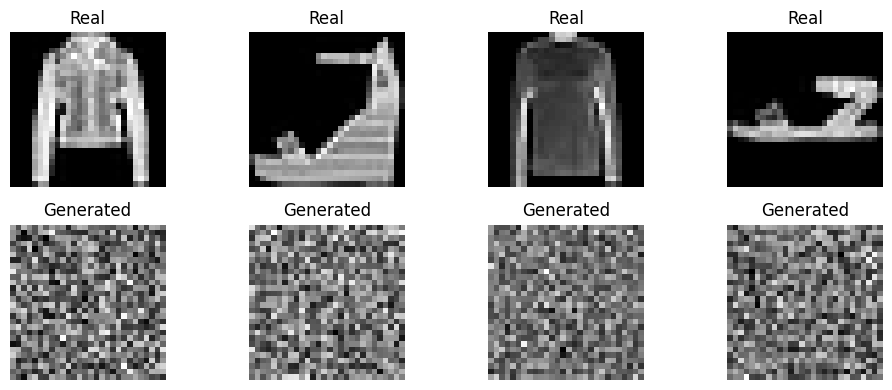

Epoch 12/20:  12%|█▏        | 15/125 [00:00<00:03, 32.77it/s]

  Batch 10: D(real)=0.990, D(fake)=0.002


Epoch 12/20:  18%|█▊        | 23/125 [00:00<00:03, 32.44it/s]

  Batch 20: D(real)=0.998, D(fake)=0.002


Epoch 12/20:  28%|██▊       | 35/125 [00:01<00:03, 26.90it/s]

  Batch 30: D(real)=0.986, D(fake)=0.003


Epoch 12/20:  34%|███▍      | 43/125 [00:01<00:02, 29.47it/s]

  Batch 40: D(real)=0.990, D(fake)=0.002


Epoch 12/20:  44%|████▍     | 55/125 [00:01<00:02, 32.18it/s]

  Batch 50: D(real)=0.993, D(fake)=0.002


Epoch 12/20:  50%|█████     | 63/125 [00:02<00:02, 30.27it/s]

  Batch 60: D(real)=0.996, D(fake)=0.002


Epoch 12/20:  60%|██████    | 75/125 [00:02<00:01, 31.31it/s]

  Batch 70: D(real)=0.925, D(fake)=0.002


Epoch 12/20:  66%|██████▋   | 83/125 [00:02<00:01, 31.94it/s]

  Batch 80: D(real)=0.998, D(fake)=0.002


Epoch 12/20:  76%|███████▌  | 95/125 [00:03<00:00, 33.68it/s]

  Batch 90: D(real)=0.998, D(fake)=0.002


Epoch 12/20:  82%|████████▏ | 103/125 [00:03<00:00, 32.04it/s]

  Batch 100: D(real)=0.941, D(fake)=0.002


Epoch 12/20:  90%|█████████ | 113/125 [00:03<00:00, 24.89it/s]

  Batch 110: D(real)=0.997, D(fake)=0.002


Epoch 12/20: 100%|██████████| 125/125 [00:04<00:00, 29.26it/s]

  Batch 120: D(real)=1.000, D(fake)=0.001
Epoch 12/20 - D Loss: 0.0122, G Loss: 6.3628


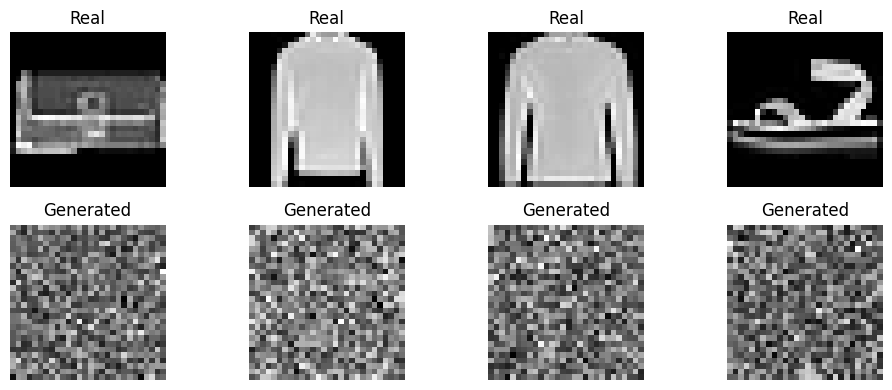

Epoch 13/20:  10%|█         | 13/125 [00:00<00:03, 31.37it/s]

  Batch 10: D(real)=0.997, D(fake)=0.001


Epoch 13/20:  20%|██        | 25/125 [00:00<00:03, 30.64it/s]

  Batch 20: D(real)=0.990, D(fake)=0.002


Epoch 13/20:  28%|██▊       | 35/125 [00:01<00:03, 28.85it/s]

  Batch 30: D(real)=0.997, D(fake)=0.001


Epoch 13/20:  35%|███▌      | 44/125 [00:01<00:03, 25.66it/s]

  Batch 40: D(real)=0.994, D(fake)=0.002


Epoch 13/20:  42%|████▏     | 53/125 [00:01<00:02, 25.22it/s]

  Batch 50: D(real)=0.999, D(fake)=0.002


Epoch 13/20:  51%|█████     | 64/125 [00:02<00:02, 28.26it/s]

  Batch 60: D(real)=0.937, D(fake)=0.002


Epoch 13/20:  58%|█████▊    | 73/125 [00:02<00:02, 22.95it/s]

  Batch 70: D(real)=0.999, D(fake)=0.005


Epoch 13/20:  69%|██████▉   | 86/125 [00:03<00:01, 27.98it/s]

  Batch 80: D(real)=0.998, D(fake)=0.005


Epoch 13/20:  77%|███████▋  | 96/125 [00:03<00:01, 28.72it/s]

  Batch 90: D(real)=0.993, D(fake)=0.005


Epoch 13/20:  85%|████████▍ | 106/125 [00:03<00:00, 29.76it/s]

  Batch 100: D(real)=0.997, D(fake)=0.003


Epoch 13/20:  93%|█████████▎| 116/125 [00:04<00:00, 29.84it/s]

  Batch 110: D(real)=0.998, D(fake)=0.002


Epoch 13/20: 100%|██████████| 125/125 [00:04<00:00, 27.67it/s]


  Batch 120: D(real)=0.996, D(fake)=0.002
Epoch 13/20 - D Loss: 0.0114, G Loss: 6.2618


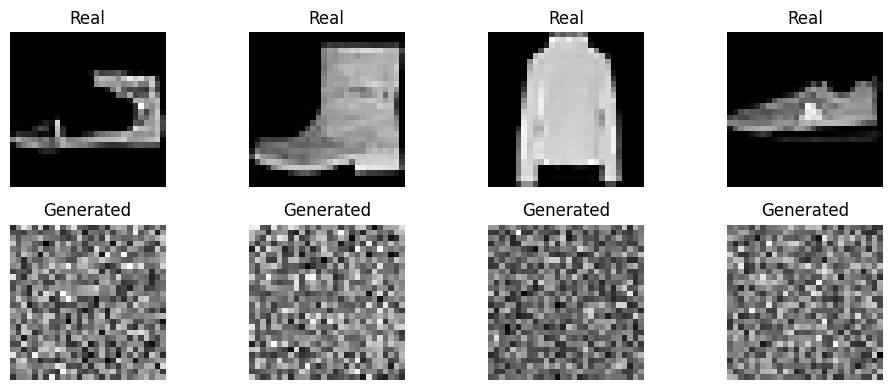

Epoch 14/20:  12%|█▏        | 15/125 [00:00<00:03, 29.50it/s]

  Batch 10: D(real)=0.998, D(fake)=0.002


Epoch 14/20:  20%|██        | 25/125 [00:00<00:04, 23.33it/s]

  Batch 20: D(real)=1.000, D(fake)=0.002


Epoch 14/20:  28%|██▊       | 35/125 [00:01<00:03, 27.54it/s]

  Batch 30: D(real)=0.995, D(fake)=0.001


Epoch 14/20:  36%|███▌      | 45/125 [00:01<00:02, 29.18it/s]

  Batch 40: D(real)=0.996, D(fake)=0.002


Epoch 14/20:  44%|████▍     | 55/125 [00:02<00:02, 28.20it/s]

  Batch 50: D(real)=0.991, D(fake)=0.001


Epoch 14/20:  51%|█████     | 64/125 [00:02<00:02, 27.39it/s]

  Batch 60: D(real)=0.998, D(fake)=0.002


Epoch 14/20:  58%|█████▊    | 73/125 [00:02<00:02, 24.85it/s]

  Batch 70: D(real)=1.000, D(fake)=0.001


Epoch 14/20:  66%|██████▋   | 83/125 [00:03<00:01, 27.78it/s]

  Batch 80: D(real)=0.992, D(fake)=0.001


Epoch 14/20:  76%|███████▌  | 95/125 [00:03<00:01, 27.01it/s]

  Batch 90: D(real)=0.951, D(fake)=0.002


Epoch 14/20:  83%|████████▎ | 104/125 [00:03<00:00, 25.90it/s]

  Batch 100: D(real)=0.994, D(fake)=0.003


Epoch 14/20:  90%|█████████ | 113/125 [00:04<00:00, 22.68it/s]

  Batch 110: D(real)=1.000, D(fake)=0.002


Epoch 14/20: 100%|██████████| 125/125 [00:04<00:00, 26.06it/s]

  Batch 120: D(real)=0.996, D(fake)=0.002
Epoch 14/20 - D Loss: 0.0095, G Loss: 6.6095


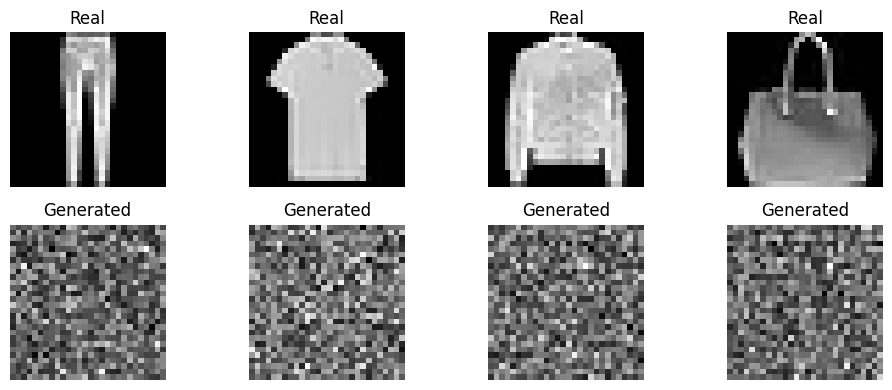

Epoch 15/20:  12%|█▏        | 15/125 [00:00<00:03, 30.87it/s]

  Batch 10: D(real)=0.996, D(fake)=0.002


Epoch 15/20:  18%|█▊        | 23/125 [00:00<00:03, 31.13it/s]

  Batch 20: D(real)=1.000, D(fake)=0.002


Epoch 15/20:  28%|██▊       | 35/125 [00:01<00:02, 30.54it/s]

  Batch 30: D(real)=0.996, D(fake)=0.001


Epoch 15/20:  34%|███▍      | 43/125 [00:01<00:02, 29.56it/s]

  Batch 40: D(real)=0.996, D(fake)=0.001


Epoch 15/20:  44%|████▍     | 55/125 [00:01<00:02, 31.37it/s]

  Batch 50: D(real)=0.975, D(fake)=0.001


Epoch 15/20:  52%|█████▏    | 65/125 [00:02<00:02, 25.83it/s]

  Batch 60: D(real)=0.994, D(fake)=0.002


Epoch 15/20:  60%|██████    | 75/125 [00:02<00:01, 27.68it/s]

  Batch 70: D(real)=0.993, D(fake)=0.002


Epoch 15/20:  68%|██████▊   | 85/125 [00:02<00:01, 29.65it/s]

  Batch 80: D(real)=0.999, D(fake)=0.001


Epoch 15/20:  75%|███████▌  | 94/125 [00:03<00:01, 28.23it/s]

  Batch 90: D(real)=0.999, D(fake)=0.002


Epoch 15/20:  82%|████████▏ | 103/125 [00:03<00:00, 24.56it/s]

  Batch 100: D(real)=1.000, D(fake)=0.001


Epoch 15/20:  92%|█████████▏| 115/125 [00:04<00:00, 24.84it/s]

  Batch 110: D(real)=0.996, D(fake)=0.001


Epoch 15/20: 100%|██████████| 125/125 [00:04<00:00, 27.57it/s]

  Batch 120: D(real)=0.978, D(fake)=0.002
Epoch 15/20 - D Loss: 0.0081, G Loss: 6.6299


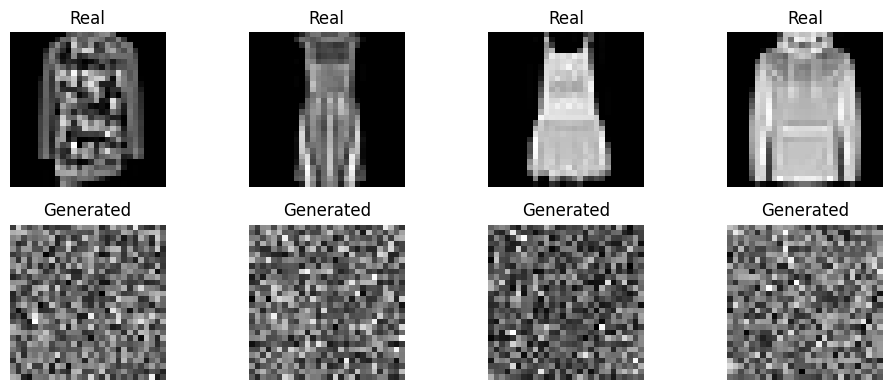

Epoch 16/20:  11%|█         | 14/125 [00:00<00:03, 28.55it/s]

  Batch 10: D(real)=0.997, D(fake)=0.001


Epoch 16/20:  19%|█▉        | 24/125 [00:00<00:03, 29.72it/s]

  Batch 20: D(real)=0.997, D(fake)=0.003


Epoch 16/20:  26%|██▌       | 32/125 [00:01<00:03, 30.29it/s]

  Batch 30: D(real)=0.999, D(fake)=0.002


Epoch 16/20:  36%|███▌      | 45/125 [00:01<00:02, 27.77it/s]

  Batch 40: D(real)=0.998, D(fake)=0.002


Epoch 16/20:  44%|████▍     | 55/125 [00:01<00:02, 28.90it/s]

  Batch 50: D(real)=0.999, D(fake)=0.002


Epoch 16/20:  51%|█████     | 64/125 [00:02<00:02, 24.92it/s]

  Batch 60: D(real)=0.999, D(fake)=0.001


Epoch 16/20:  58%|█████▊    | 73/125 [00:02<00:02, 18.84it/s]

  Batch 70: D(real)=0.997, D(fake)=0.001


Epoch 16/20:  66%|██████▌   | 82/125 [00:03<00:02, 19.81it/s]

  Batch 80: D(real)=0.994, D(fake)=0.001


Epoch 16/20:  74%|███████▍  | 93/125 [00:04<00:01, 18.60it/s]

  Batch 90: D(real)=0.967, D(fake)=0.001


Epoch 16/20:  82%|████████▏ | 102/125 [00:04<00:01, 21.58it/s]

  Batch 100: D(real)=0.998, D(fake)=0.002


Epoch 16/20:  91%|█████████ | 114/125 [00:04<00:00, 22.84it/s]

  Batch 110: D(real)=0.998, D(fake)=0.002


Epoch 16/20:  98%|█████████▊| 122/125 [00:05<00:00, 13.49it/s]

  Batch 120: D(real)=0.998, D(fake)=0.001


Epoch 16/20: 100%|██████████| 125/125 [00:05<00:00, 21.01it/s]


Epoch 16/20 - D Loss: 0.0071, G Loss: 6.6543


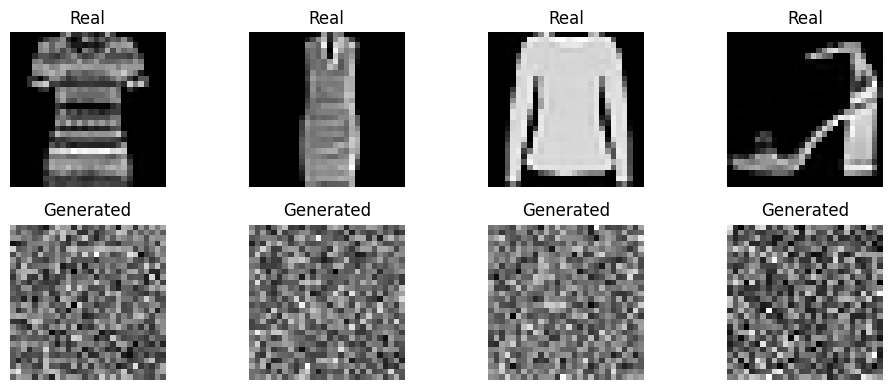

Epoch 17/20:   8%|▊         | 10/125 [00:01<00:18,  6.38it/s]

  Batch 10: D(real)=0.996, D(fake)=0.001


Epoch 17/20:  18%|█▊        | 22/125 [00:02<00:09, 11.27it/s]

  Batch 20: D(real)=0.998, D(fake)=0.002


Epoch 17/20:  26%|██▋       | 33/125 [00:03<00:07, 12.82it/s]

  Batch 30: D(real)=0.994, D(fake)=0.001


Epoch 17/20:  34%|███▍      | 43/125 [00:04<00:04, 16.89it/s]

  Batch 40: D(real)=0.998, D(fake)=0.001


Epoch 17/20:  42%|████▏     | 52/125 [00:04<00:03, 23.37it/s]

  Batch 50: D(real)=0.999, D(fake)=0.001


Epoch 17/20:  51%|█████     | 64/125 [00:05<00:02, 24.48it/s]

  Batch 60: D(real)=0.997, D(fake)=0.002


Epoch 17/20:  58%|█████▊    | 73/125 [00:05<00:02, 22.72it/s]

  Batch 70: D(real)=0.998, D(fake)=0.002


Epoch 17/20:  66%|██████▌   | 82/125 [00:05<00:01, 21.63it/s]

  Batch 80: D(real)=1.000, D(fake)=0.001


Epoch 17/20:  76%|███████▌  | 95/125 [00:06<00:01, 26.13it/s]

  Batch 90: D(real)=0.999, D(fake)=0.001


Epoch 17/20:  84%|████████▍ | 105/125 [00:06<00:00, 24.92it/s]

  Batch 100: D(real)=0.983, D(fake)=0.004


Epoch 17/20:  89%|████████▉ | 111/125 [00:07<00:00, 24.32it/s]

  Batch 110: D(real)=0.998, D(fake)=0.005


Epoch 17/20:  98%|█████████▊| 123/125 [00:07<00:00, 21.22it/s]

  Batch 120: D(real)=1.000, D(fake)=0.002


Epoch 17/20: 100%|██████████| 125/125 [00:07<00:00, 16.01it/s]


Epoch 17/20 - D Loss: 0.0067, G Loss: 6.4584


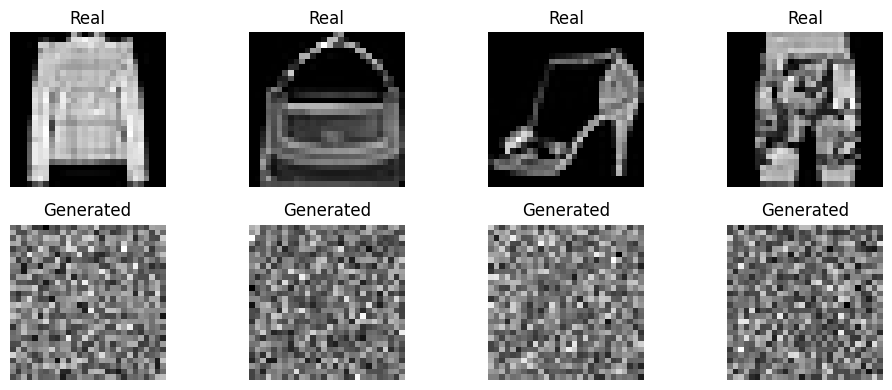

Epoch 18/20:  12%|█▏        | 15/125 [00:00<00:04, 27.45it/s]

  Batch 10: D(real)=1.000, D(fake)=0.002


Epoch 18/20:  19%|█▉        | 24/125 [00:00<00:03, 25.92it/s]

  Batch 20: D(real)=1.000, D(fake)=0.002


Epoch 18/20:  27%|██▋       | 34/125 [00:01<00:03, 26.59it/s]

  Batch 30: D(real)=0.999, D(fake)=0.001


Epoch 18/20:  33%|███▎      | 41/125 [00:01<00:03, 25.29it/s]

  Batch 40: D(real)=0.999, D(fake)=0.001


Epoch 18/20:  43%|████▎     | 54/125 [00:02<00:02, 26.46it/s]

  Batch 50: D(real)=0.998, D(fake)=0.001


Epoch 18/20:  51%|█████     | 64/125 [00:02<00:02, 25.63it/s]

  Batch 60: D(real)=0.998, D(fake)=0.001


Epoch 18/20:  59%|█████▉    | 74/125 [00:02<00:02, 25.30it/s]

  Batch 70: D(real)=0.999, D(fake)=0.001


Epoch 18/20:  67%|██████▋   | 84/125 [00:03<00:01, 24.81it/s]

  Batch 80: D(real)=0.994, D(fake)=0.001


Epoch 18/20:  74%|███████▍  | 93/125 [00:03<00:01, 21.29it/s]

  Batch 90: D(real)=0.997, D(fake)=0.001


Epoch 18/20:  84%|████████▍ | 105/125 [00:04<00:00, 22.03it/s]

  Batch 100: D(real)=0.999, D(fake)=0.001


Epoch 18/20:  91%|█████████ | 114/125 [00:04<00:00, 22.90it/s]

  Batch 110: D(real)=1.000, D(fake)=0.001


Epoch 18/20: 100%|██████████| 125/125 [00:05<00:00, 23.84it/s]

  Batch 120: D(real)=0.997, D(fake)=0.001
Epoch 18/20 - D Loss: 0.0054, G Loss: 6.9526


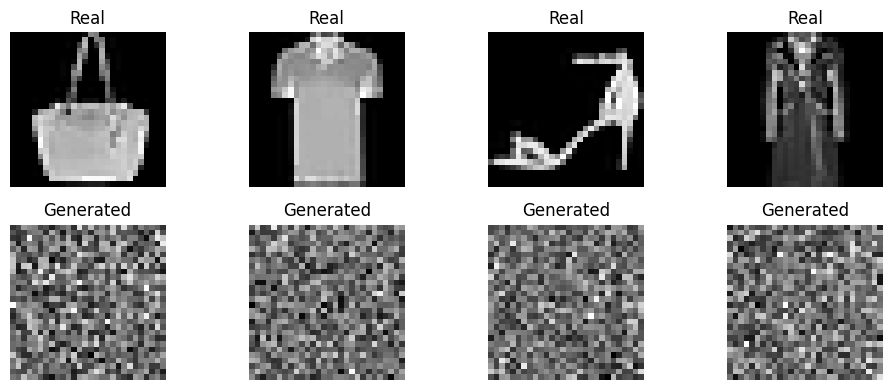

Epoch 19/20:  10%|▉         | 12/125 [00:00<00:05, 19.08it/s]

  Batch 10: D(real)=1.000, D(fake)=0.001


Epoch 19/20:  19%|█▉        | 24/125 [00:01<00:04, 22.26it/s]

  Batch 20: D(real)=1.000, D(fake)=0.001


Epoch 19/20:  26%|██▋       | 33/125 [00:01<00:04, 22.22it/s]

  Batch 30: D(real)=0.999, D(fake)=0.001


Epoch 19/20:  37%|███▋      | 46/125 [00:02<00:03, 26.31it/s]

  Batch 40: D(real)=0.998, D(fake)=0.001


Epoch 19/20:  44%|████▍     | 55/125 [00:02<00:02, 25.94it/s]

  Batch 50: D(real)=0.997, D(fake)=0.001


Epoch 19/20:  51%|█████     | 64/125 [00:02<00:02, 26.65it/s]

  Batch 60: D(real)=0.994, D(fake)=0.001


Epoch 19/20:  58%|█████▊    | 73/125 [00:03<00:02, 24.54it/s]

  Batch 70: D(real)=0.999, D(fake)=0.001


Epoch 19/20:  66%|██████▌   | 82/125 [00:03<00:01, 21.82it/s]

  Batch 80: D(real)=0.987, D(fake)=0.001


Epoch 19/20:  74%|███████▎  | 92/125 [00:04<00:01, 21.56it/s]

  Batch 90: D(real)=0.998, D(fake)=0.001


KeyboardInterrupt: 

In [29]:
def train_original_gan_loss(gan, train_loader, grid, num_epochs=10, device="cpu"):
    # Optimizers with different learning rates
    optimizer_g = optim.Adam(gan.generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(gan.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    
    # Training stats
    d_losses = []
    g_losses = []
    
    gan.train()
    
    # Small epsilon to prevent log(0)
    eps = 1e-8
    
    for epoch in range(num_epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0
        batch_count = 0
        
        for real_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            batch_count += 1
            
            # ---------------------
            # Train Discriminator
            # ---------------------
            if batch_count % 3 == 0:  # Train D less frequently than G
                optimizer_d.zero_grad()
                
                # Real images
                d_real = gan.discriminator(real_images)
                
                # Fake images
                z = torch.randn(batch_size, gan.z_dim).to(device) * 0.5
                fake_images, _ = gan.generator(z, grid)
                d_fake = gan.discriminator(fake_images.detach())
                
                # Original GAN loss formulation
                d_loss = -torch.mean(torch.log(d_real + eps) + torch.log(1 - d_fake + eps))
                
                # Backprop
                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(gan.discriminator.parameters(), 1.0)
                optimizer_d.step()
            else:
                # Just compute loss for tracking
                with torch.no_grad():
                    d_real = gan.discriminator(real_images)
                    z = torch.randn(batch_size, gan.z_dim).to(device) * 0.5
                    fake_images, _ = gan.generator(z, grid)
                    d_fake = gan.discriminator(fake_images)
                    d_loss = -torch.mean(torch.log(d_real + eps) + torch.log(1 - d_fake + eps))
            
            # ---------------------
            # Train Generator
            # ---------------------
            optimizer_g.zero_grad()
            
            # Generate new fake images
            z = torch.randn(batch_size, gan.z_dim).to(device) * 0.5
            fake_images, _ = gan.generator(z, grid)
            d_fake = gan.discriminator(fake_images)
            
            # Original non-saturating generator loss
            g_loss = -torch.mean(torch.log(d_fake + eps))
            
            # Backprop
            g_loss.backward()
            torch.nn.utils.clip_grad_norm_(gan.generator.parameters(), 1.0)
            optimizer_g.step()
            
            # Record losses
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            
            # Monitor progress
            if batch_count % 10 == 0:
                d_real_mean = d_real.mean().item()
                d_fake_mean = d_fake.mean().item()
                print(f"  Batch {batch_count}: D(real)={d_real_mean:.3f}, D(fake)={d_fake_mean:.3f}")
        
        # Calculate average losses for this epoch
        epoch_d_loss /= batch_count
        epoch_g_loss /= batch_count
        
        # Save losses for plotting
        d_losses.append(epoch_d_loss)
        g_losses.append(epoch_g_loss)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - D Loss: {epoch_d_loss:.4f}, G Loss: {epoch_g_loss:.4f}")
        
        # Visualize sample images every epoch
        visualize_samples(gan, real_images, fake_images, device)
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Losses (Original Formulation)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return gan, d_losses, g_losses

# Modified main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create coordinate grid
    grid = get_mgrid(28, dim=2, num_bands=2).to(device)
    
    # Create simplified GAN
    gan = SimpleGAN(z_dim=Z_DIM).to(device)
    
    # Train with original GAN loss formulation
    gan, d_losses, g_losses = train_original_gan_loss(gan, train_loader, grid, num_epochs=20, device=device)
    
    # Generate final samples
    gan.eval()
    with torch.no_grad():
        z = torch.randn(8, Z_DIM).to(device) * 0.5
        generated_images, _ = gan.generator(z, grid)
        
        plt.figure(figsize=(12, 3))
        for i in range(8):
            plt.subplot(1, 8, i+1)
            plt.imshow(generated_images[i].cpu().squeeze(0), cmap="gray")
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()